In [1]:
## Imports
import pandas as pd
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
current_directory = os.getcwd()
print(current_directory)
import shap
shap.initjs()

d:\OneDrive\ML\Model


C:\Users\Ssach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##Input
file_name = 'Data.xlsx'
sheet_name='Mean_Data'
sheet_name_train = 'Pred_Data'
## Model Parameters
Label_1= 'Project_Type'
Label_2= 'Rock_Name'
label = ['Rock','Injection','All']

label_train = 'All'


obj_param = 'Moment_Max'
cat_feat= Label_1


data_read = pd.read_excel(f"CSVs/ML_Inputs/{file_name}",sheet_name=sheet_name)
data_pred_read = pd.read_excel(f"CSVs/ML_Inputs/{file_name}",sheet_name=sheet_name_train)

cols = data_read.columns.tolist()
cols = [col for col in cols if col not in [cat_feat]]

if label_train == 'Rock':
    drop_cols = ['Inj_Vol','Inj_Depth ','Inj_Rate','Rock_Name',obj_param]
if label_train == 'Injection':
    drop_cols = [col for col in cols if col not in ['Injected Volume', 'Injected Depth', 'Injected Rate']]
if label_train == 'All':
    drop_cols = ['Project_Type','Rock_Name',obj_param,'Thermal Conductivity',"Young's Modulus",'Bulk Modulus','UCS','Thermal Expansion Coefficient']




print(data_read.columns)
print(cat_feat)
print(obj_param)
LR = 0.85
MD = 10


## FIG 1_ Validation Plor
title_1 = f'Validation Plot_{label_train}_{LR}'
title_2 = f'Bar Plot_{label_train}_{cat_feat}_{LR}'
title_3 = f'validation Plot_{label_train}_{cat_feat}_{LR}'
title_4 = f'Bar Plot_{label_train}_{cat_feat}_{LR}'



Index(['Rock_Name', 'Project_Type', 'Bulk Density', 'Effective Porosity',
       'Intrinsic Permeability', 'Young's Modulus', 'Poisson's Ratio',
       'Bulk Modulus', 'Shear Modulus', 'UCS', 'Thermal Conductivity',
       'Thermal Expansion Coefficient', 'Biot Coefficinet', 'Injected Volume',
       'Injected Depth', 'Injected Rate', 'Moment_Max'],
      dtype='object')
Project_Type
Moment_Max


In [3]:
data = data_read
#data = data_read[data_read['Injected Volume'] > 1].copy()
#data = data.reset_index(drop=True)
print(data.shape)
data[cat_feat] = data[cat_feat].astype('category')
train_data = data.drop(columns=drop_cols)
print(train_data.columns)
train_ft = train_data.columns.tolist()
train_obj = data[obj_param]
train_data = lgb.Dataset(train_data, label=train_obj, feature_name=train_ft)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 21,
    'learning_rate': 0.85,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'min_gain_to_split': 0.01,
    'verbosity': -1,
    'seed': 84,
    'max_depth': 5
}

# Training the model
model = lgb.train(params, train_data, num_boost_round=100)
model.save_model('model.txt')

pred_data = data
pred_data[cat_feat] = pred_data[cat_feat].astype('category')
Y = pred_data[obj_param] 
Pred_m1_data = pred_data.drop(columns=drop_cols)
y_pred = model.predict(Pred_m1_data, num_iteration=model.best_iteration)

predicted_df = Pred_m1_data.copy()
predicted_df[obj_param] = y_pred

mse = mean_squared_error(Y, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}',len(y_pred))

mo_pred = 10 ** ((3/2) * (y_pred + 6.07))
mo_rec = 10 ** ((3/2) * (Y + 6.07))


(157, 17)
Index(['Bulk Density', 'Effective Porosity', 'Intrinsic Permeability',
       'Poisson's Ratio', 'Shear Modulus', 'Biot Coefficinet',
       'Injected Volume', 'Injected Depth', 'Injected Rate'],
      dtype='object')
RMSE: 0.2901850308811244 157


Validation Plot_All_0.85


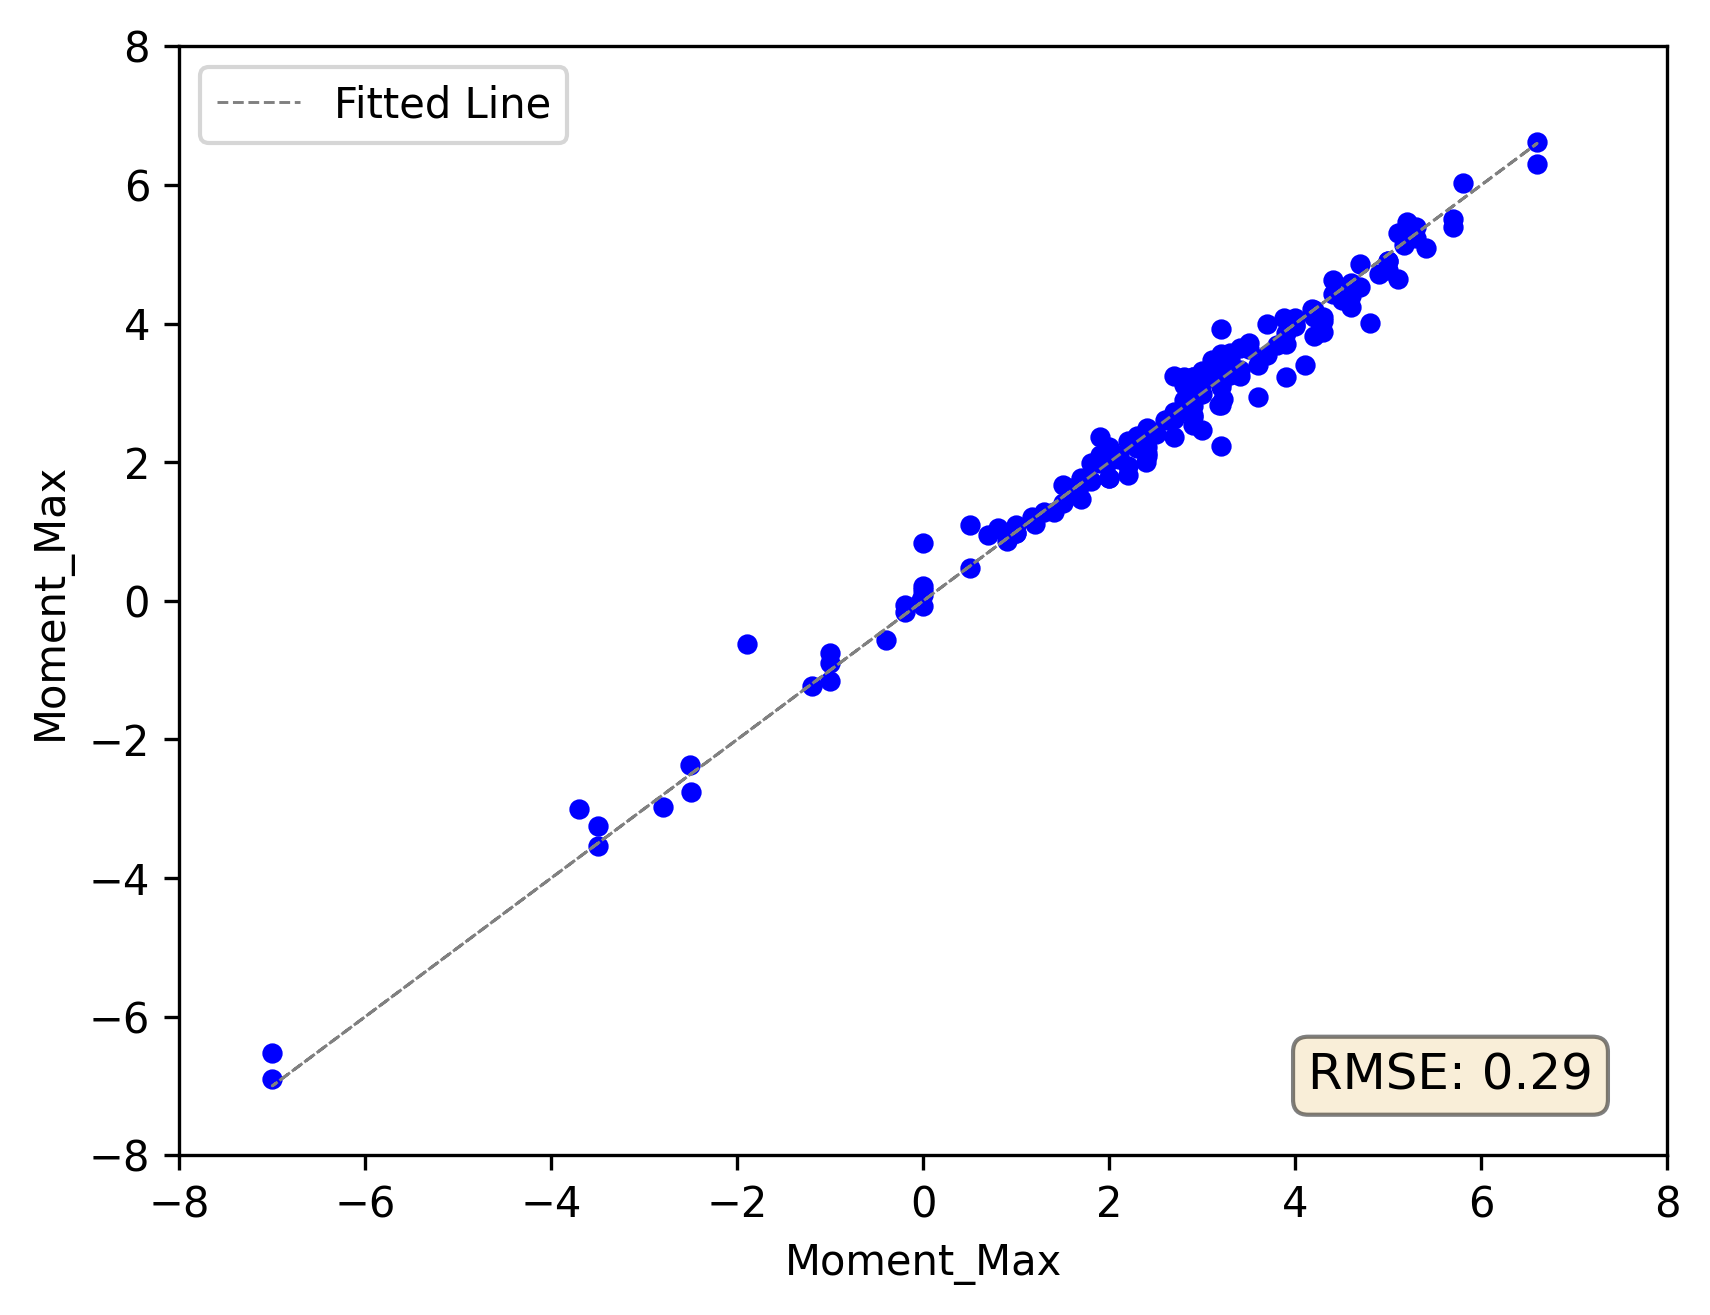

In [4]:

## Validation Plot_FIG 1 : Actual vs Predicted
plt.figure(dpi=300)
for i in range (len(y_pred)):
    # Plot line connecting actual and predicted values}
    #plt.plot([Y[i], Y[i]], [Y[i], y_pred[i]], 'g--', linewidth=1)
    # Highlight actual value with a blue circle
    plt.scatter(Y[i], y_pred[i], color='blue', s=15,)
    # Highlight predicted value with a red circle
    
plt.plot(pred_data[obj_param], pred_data[obj_param], color='gray', linestyle='--', linewidth=0.7, label='Fitted Line')
textstr = f'RMSE: {rmse:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.xlabel(obj_param)
plt.ylabel(obj_param)
#plt.title(title_1)
plt.legend()
plt.ylim(-8, 8)
plt.xlim(-8, 8)
file_path = f"PNGs/06_04/{title_1}.jpg"
#plt.savefig(file_path, format='jpg')
print(title_1)
plt.show()


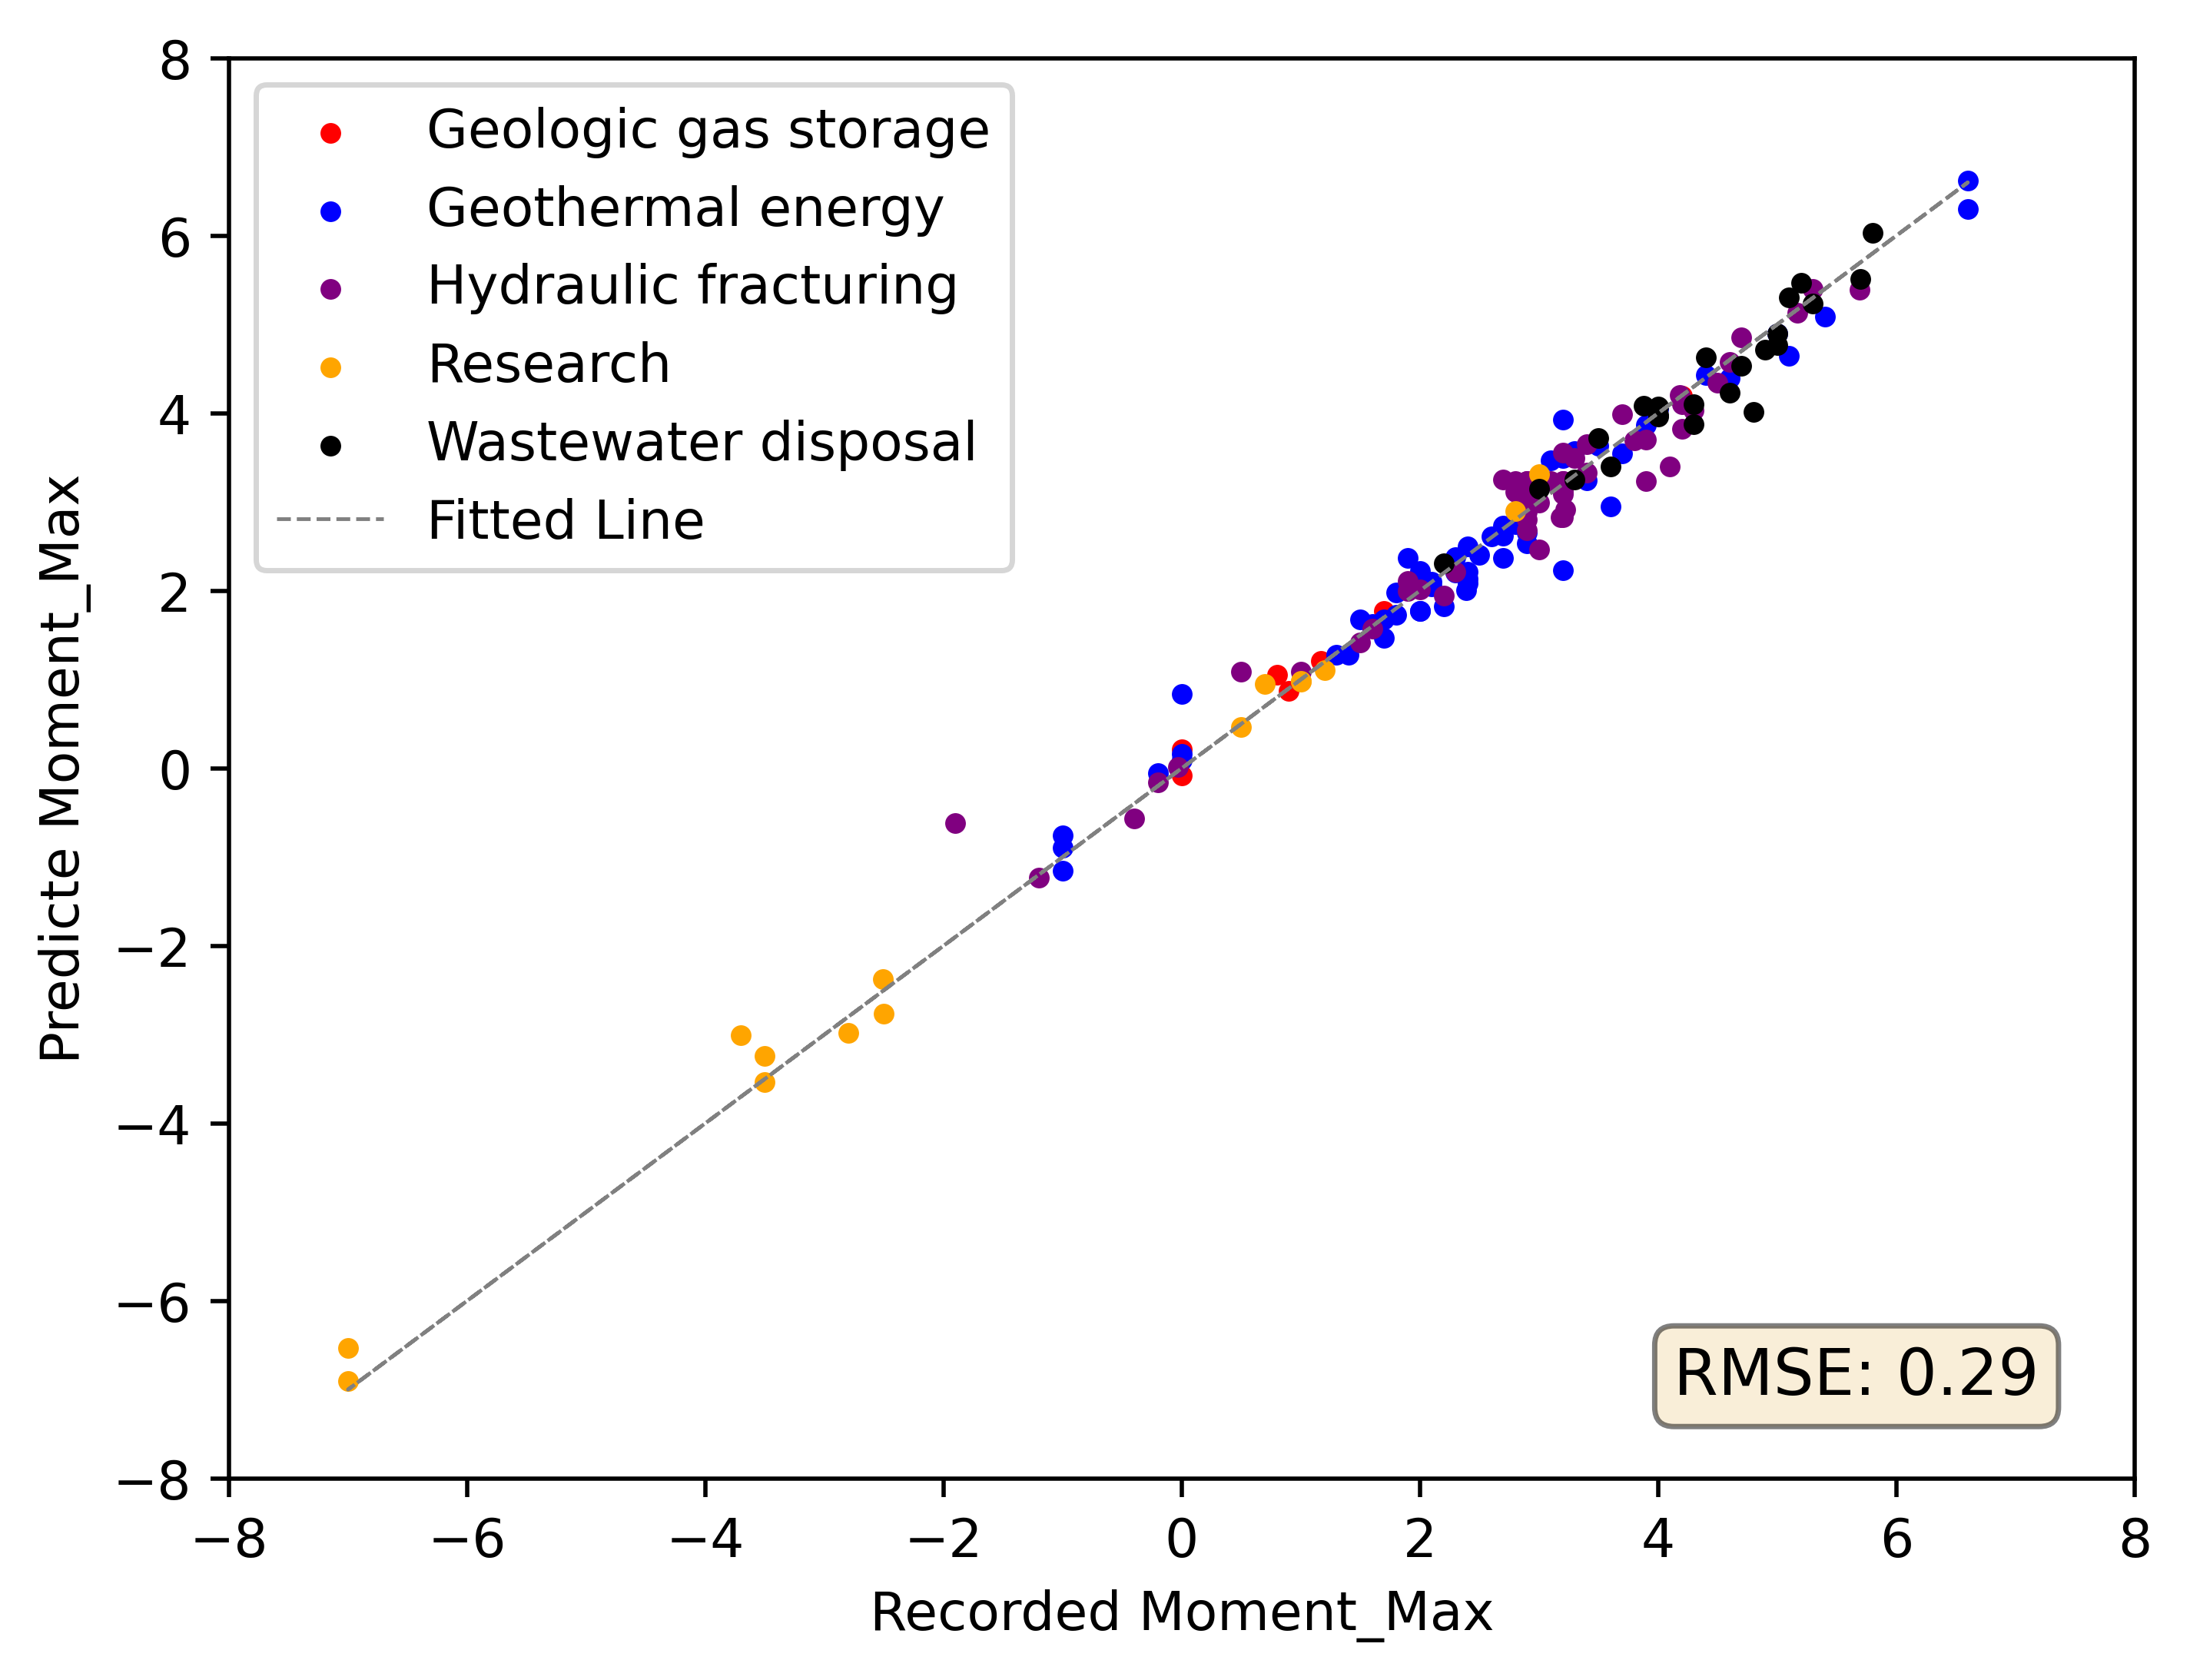

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Color mapping for each category
to_color = {
    'Geologic gas storage': 'red',
    'Geothermal energy': 'blue',
    'Hydraulic fracturing': 'purple',
    'Research': 'orange',
    'Wasterwater disposal': 'green'
}

plt.figure(dpi=500)

cat_unique = np.unique(pred_data[cat_feat])

all_actual = []
all_predicted = []

for project in cat_unique:
    cat_data = pred_data[pred_data[cat_feat] == project]
    
    Y_rock = cat_data[obj_param]
    y_pred_rock = model.predict(cat_data.drop(columns=drop_cols), num_iteration=model.best_iteration)

    all_actual.extend(Y_rock)
    all_predicted.extend(y_pred_rock)

    plt.scatter(
        Y_rock, y_pred_rock,
        label=project,
        s=15,
        marker='o',                    # solid circle
        color=to_color.get(project, 'black'),  # fill color only
        linewidths=0,
        zorder=2
    )

# Reference line for perfect prediction
plt.plot(pred_data[obj_param], pred_data[obj_param], color='gray', linestyle='--', linewidth=0.7, label='Fitted Line')

textstr = f'RMSE: {rmse:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=props)



# Axis labeling and limits
plt.xlabel('Recorded Moment_Max')
plt.ylabel('Predicte Moment_Max')
#plt.title(title_3)

plt.legend()
plt.ylim(-8, 8)
plt.xlim(-8, 8)

# Save and show
file_path = f"PNGs/06_04/{title_3}.jpg"
#plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=300)
plt.show()


Bar Plot_All_Project_Type_0.85


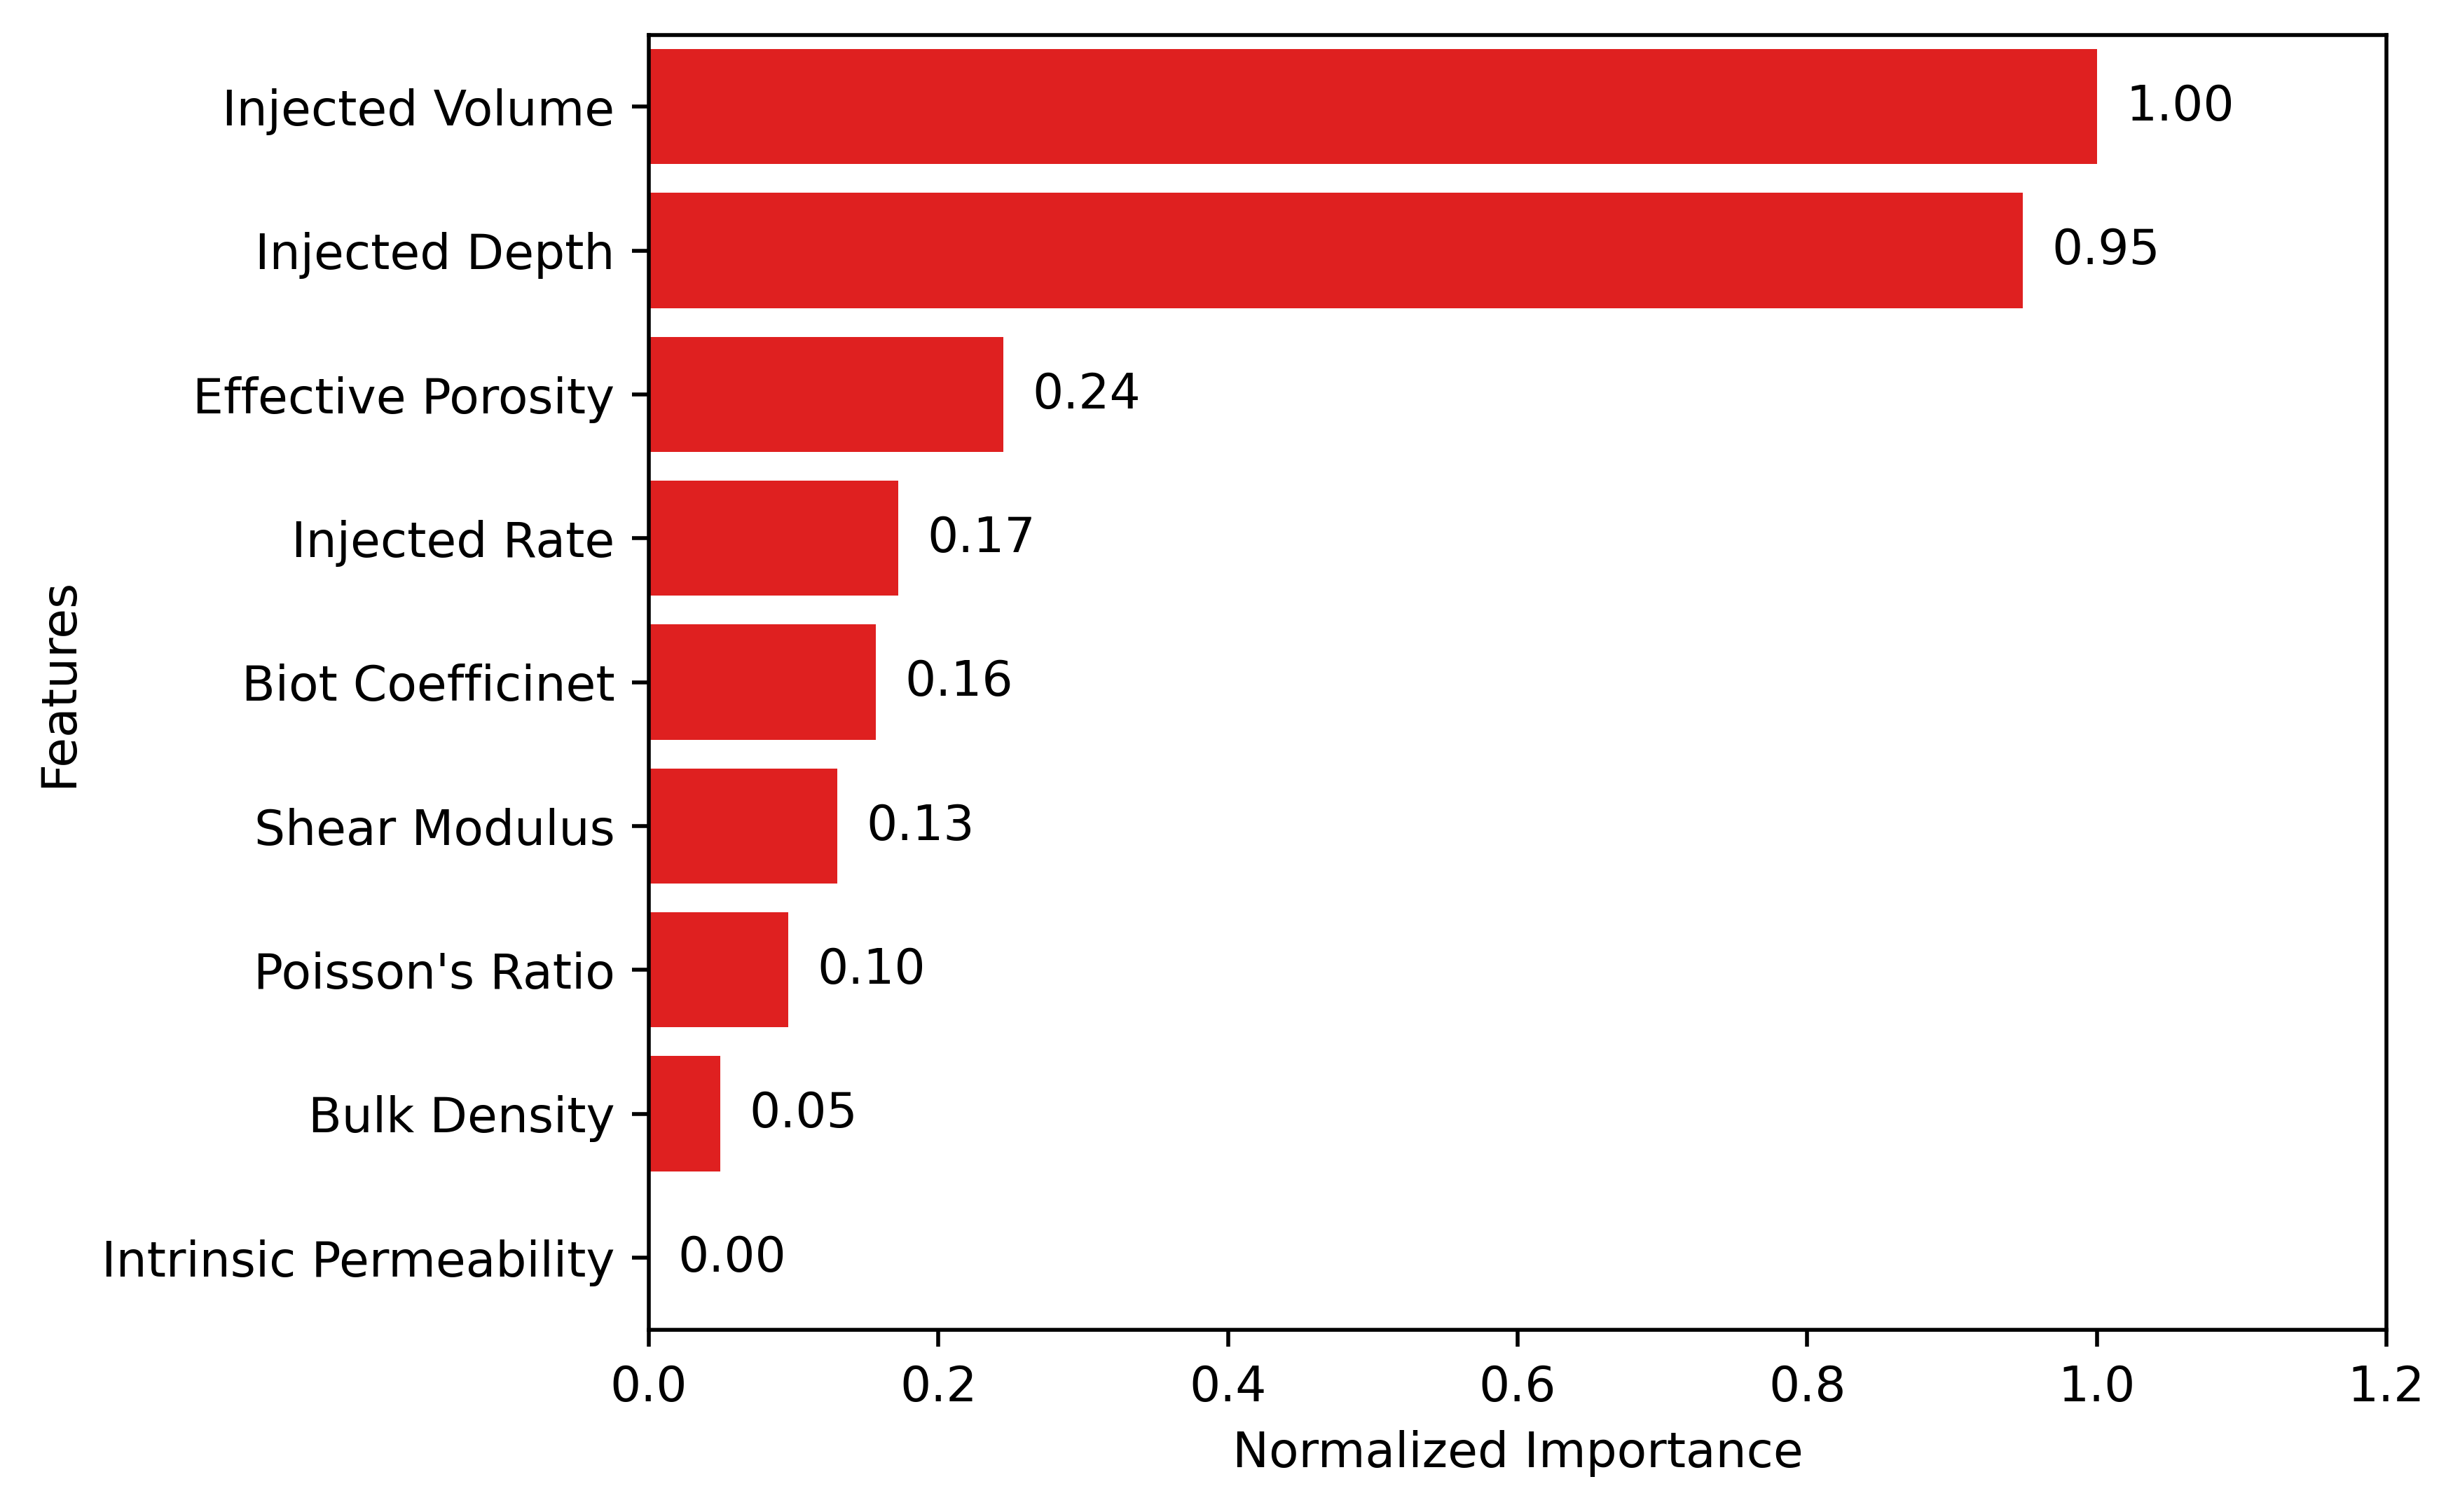

In [6]:
## Feature Importance Bar Plot FIG 3
feature_importances = model.feature_importance(importance_type='gain')

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': train_ft,  # Feature names
    'importance': feature_importances
})

#feature_importance_df = feature_importance_df[feature_importance_df['feature'] != cat_feat].reset_index(drop=True)
#feature_importance_df = feature_importance_df[~feature_importance_df['feature'].isin(cat_feat)].reset_index(drop=True)

# Normalize importance values (Min-Max normalization)
feature_importance_df['normalized_importance'] = (
    (feature_importance_df['importance'] - feature_importance_df['importance'].min()) /
    (feature_importance_df['importance'].max() - feature_importance_df['importance'].min())
)

# Sort by normalized importance (ascending order)
feature_importance_df = feature_importance_df.sort_values(by='normalized_importance', ascending=False).reset_index(drop=True)

# Set figure size
plt.figure(dpi=500)
#plt.title(title_2)

bar_plot = sns.barplot(
    x='normalized_importance', 
    y='feature', 
    data=feature_importance_df, 
    color='red',
    order=feature_importance_df['feature']  # Maintain sorted order
)

# Add annotations to bars
for index, row in feature_importance_df.iterrows():
    bar_plot.text(
        row['normalized_importance'] + 0.02, 
        index, 
        f"{row['normalized_importance']:.2f}",  # Format to 2 decimal places
        color='black', 
        ha="left", 
        va="center", 
        fontsize=10
    )

# Set x-axis limits
plt.xlim(0, 1.2)
plt.xlabel('Normalized Importance')
plt.ylabel('Features')
file_path = f"PNGs/06_04/{title_2}.jpg"
print(title_2)
#plt.savefig(file_path, format='jpg')
plt.show()


Validation Plot_All_0.85


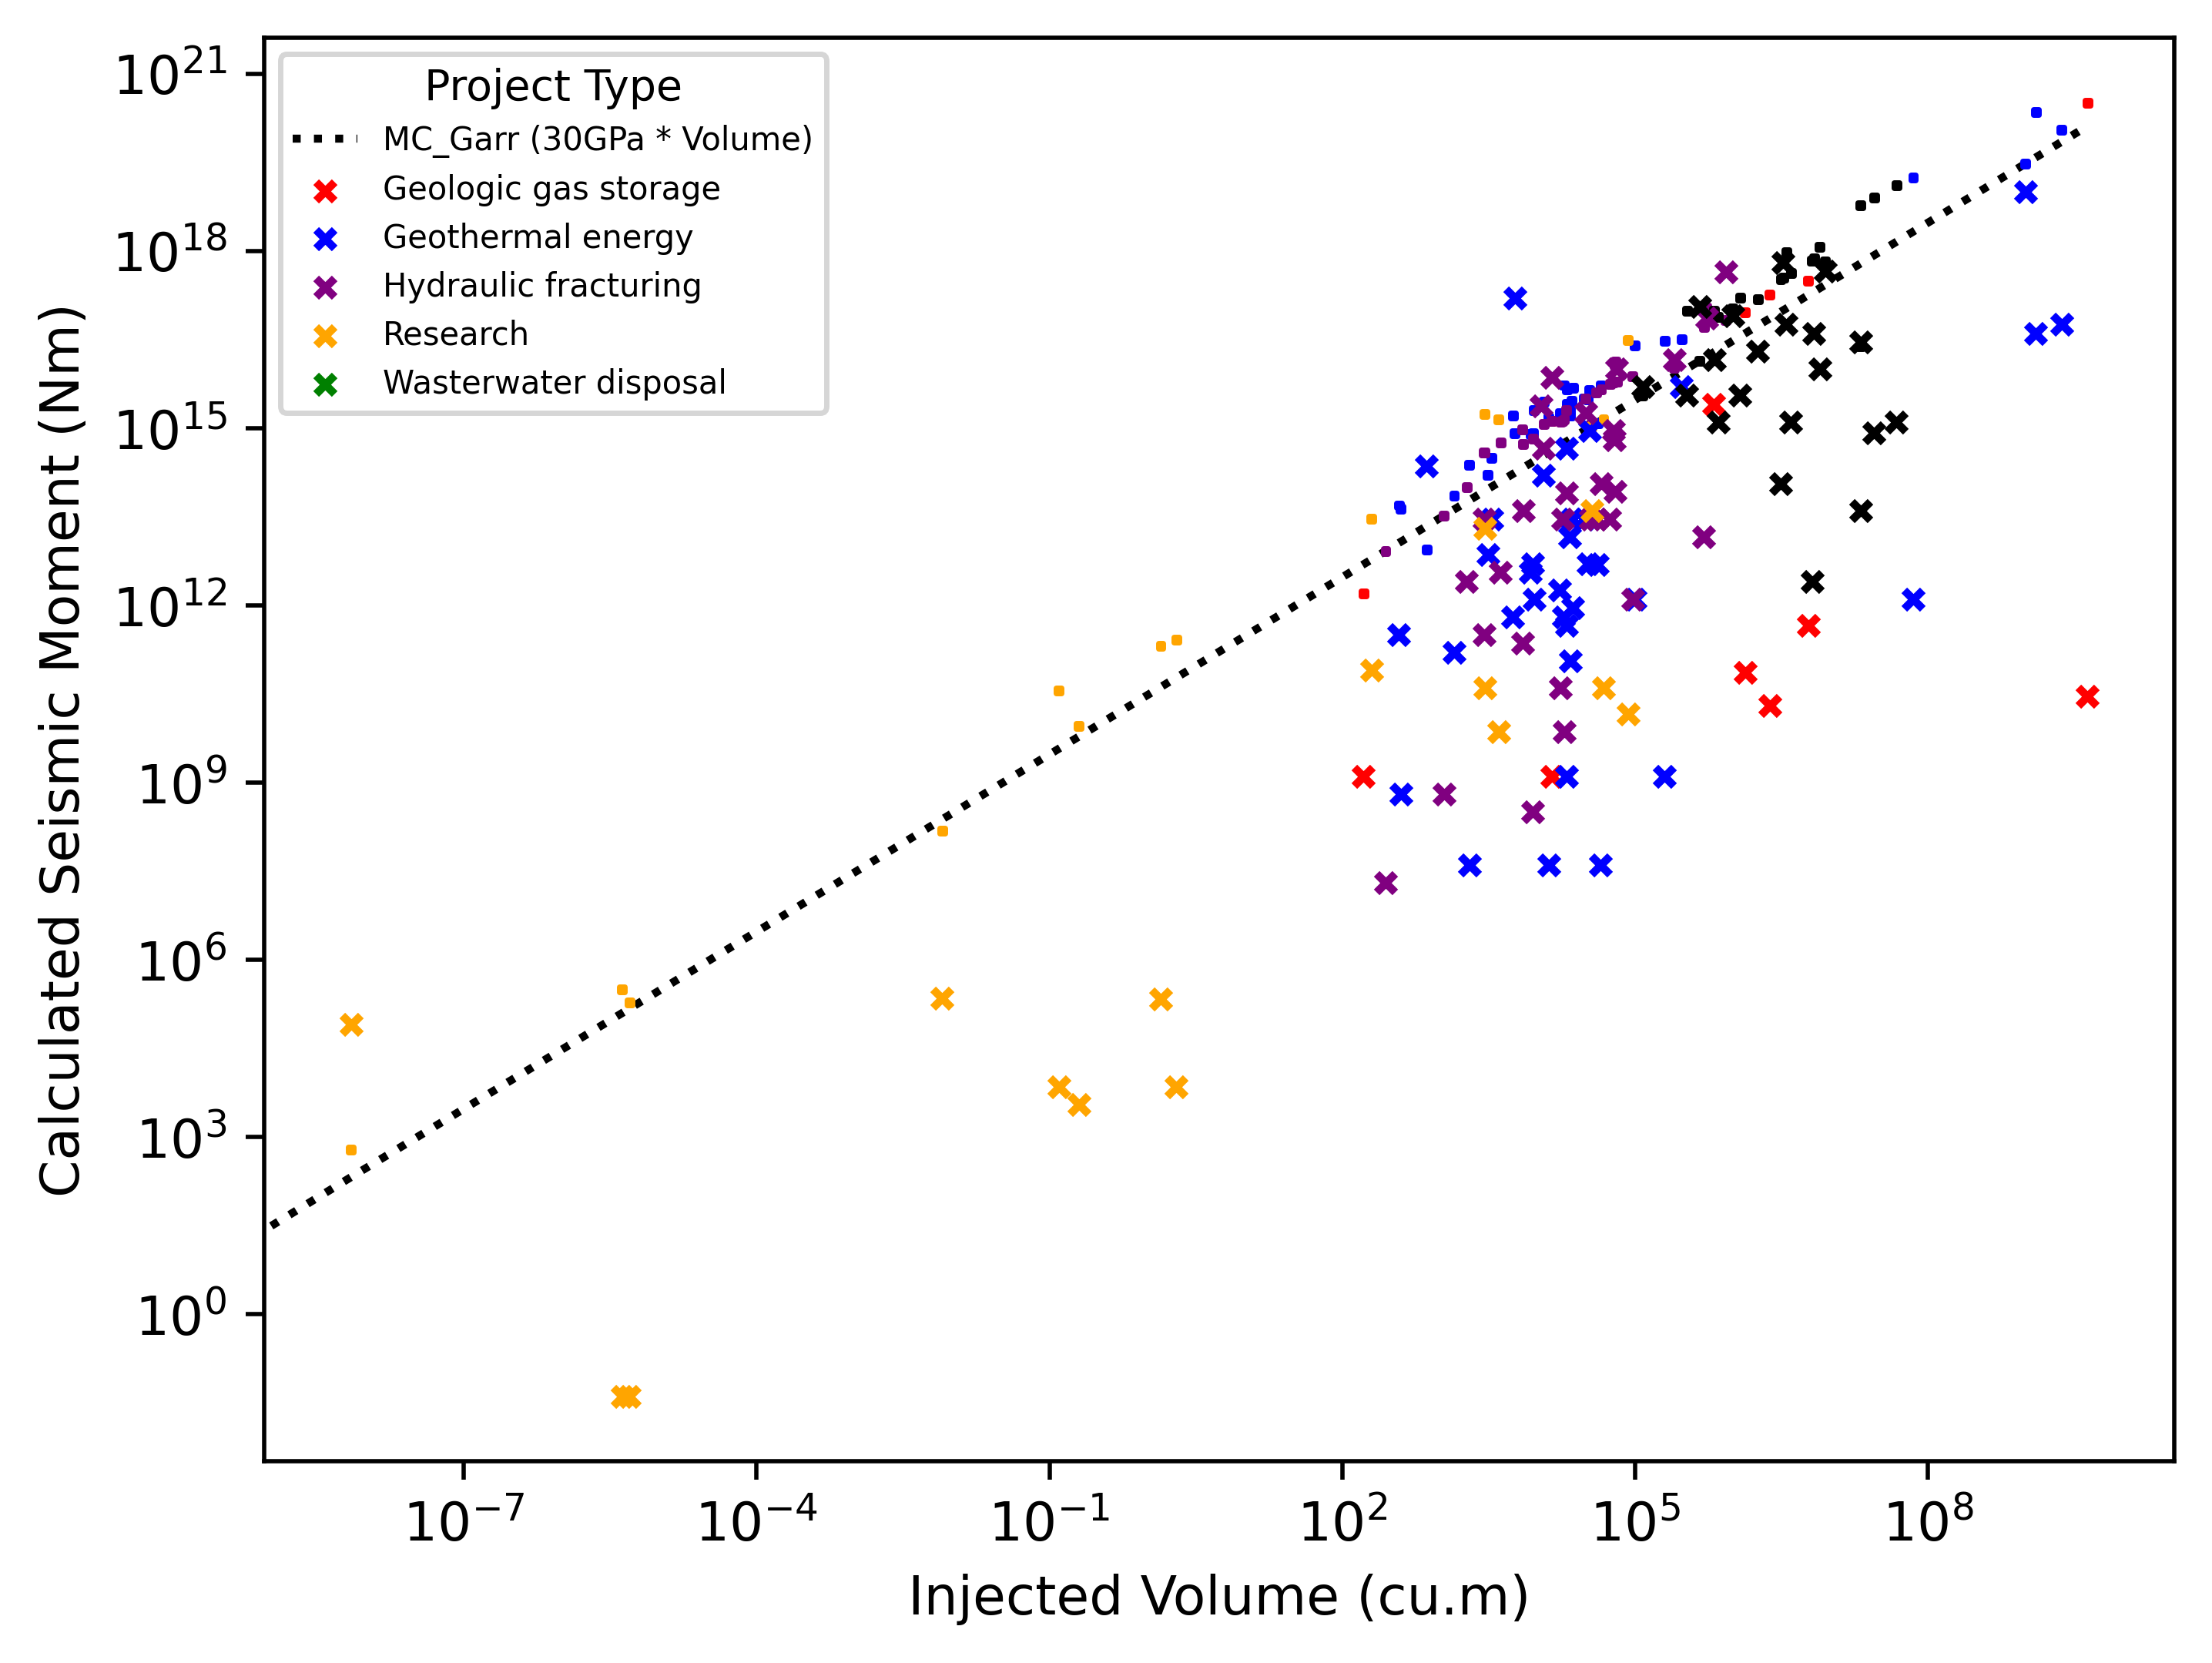

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate moment values
pred_data['Mo'] = 10 ** ((3/2) * (y_pred + 6.07))
pred_data['Mo_rec'] = 10 ** ((3/2) * (Y + 6.07))

X = pred_data['Injected Volume']
Y_MO_PRED = pred_data['Mo']
Y_MO_REC = pred_data['Mo_rec']
Y_SM = pred_data['Shear Modulus']

trend = X * 30e9  # MC_Garr trend line

# Color mapping for project types
to_color = {
    'Geologic gas storage': 'red',
    'Geothermal energy': 'blue',
    'Hydraulic fracturing': 'purple',
    'Research': 'orange',
    'Wasterwater disposal': 'green'
}

plt.figure(dpi=500)

# Plot predicted (circle), actual (X), and shear modulus (hollow square) values
for i in range(len(pred_data)):
    x_val = X.iloc[i]
    y_val_pred = Y_MO_PRED.iloc[i]
    y_val_rec = Y_MO_REC.iloc[i]
    y_val_sm = Y_SM.iloc[i]*x_val*10e9
    project_type = pred_data['Project_Type'].iloc[i]
    color = to_color.get(project_type, 'black')
    #if y_val_sm > y_val_rec:
    # Actual: X
    plt.scatter(x_val, y_val_rec, color=color, s=12, marker='x', zorder=3)

    # Shear Modulus: hollow square
    plt.scatter(x_val, y_val_sm, edgecolor=color, facecolor='none', s=1, marker='s', zorder=2)

# Sort for trend line
sorted_indices = np.argsort(X)
X_sorted = X.iloc[sorted_indices]
trend_sorted = trend.iloc[sorted_indices]
plt.plot(X_sorted, trend_sorted, color='black', linestyle=':', linewidth=1.5,label='MC_Garr (30GPa * Volume)', zorder=1)

# Axes and scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Injected Volume (cu.m)", fontsize=10)
plt.ylabel("Calculated Seismic Moment (Nm)", fontsize=10)

# Custom legend handles for project types
for project, color in to_color.items():
    plt.scatter([], [], color=color, marker='x', s=12, label=project)

# Add hollow square legend for shear modulus
#plt.scatter([], [], edgecolor='gray', facecolor='none', marker='s', s=30,
            #label='Shear Modulus (hollow square)')

# Clean, compact legend
plt.legend(fontsize=6, title="Project Type", title_fontsize=8, loc='best')

# Save & show
file_path = f"PNGs/06_04/{title_1}.jpg"
# plt.savefig(file_path, format='jpg')
print(title_1)
plt.show()


Validation Plot_All_0.85


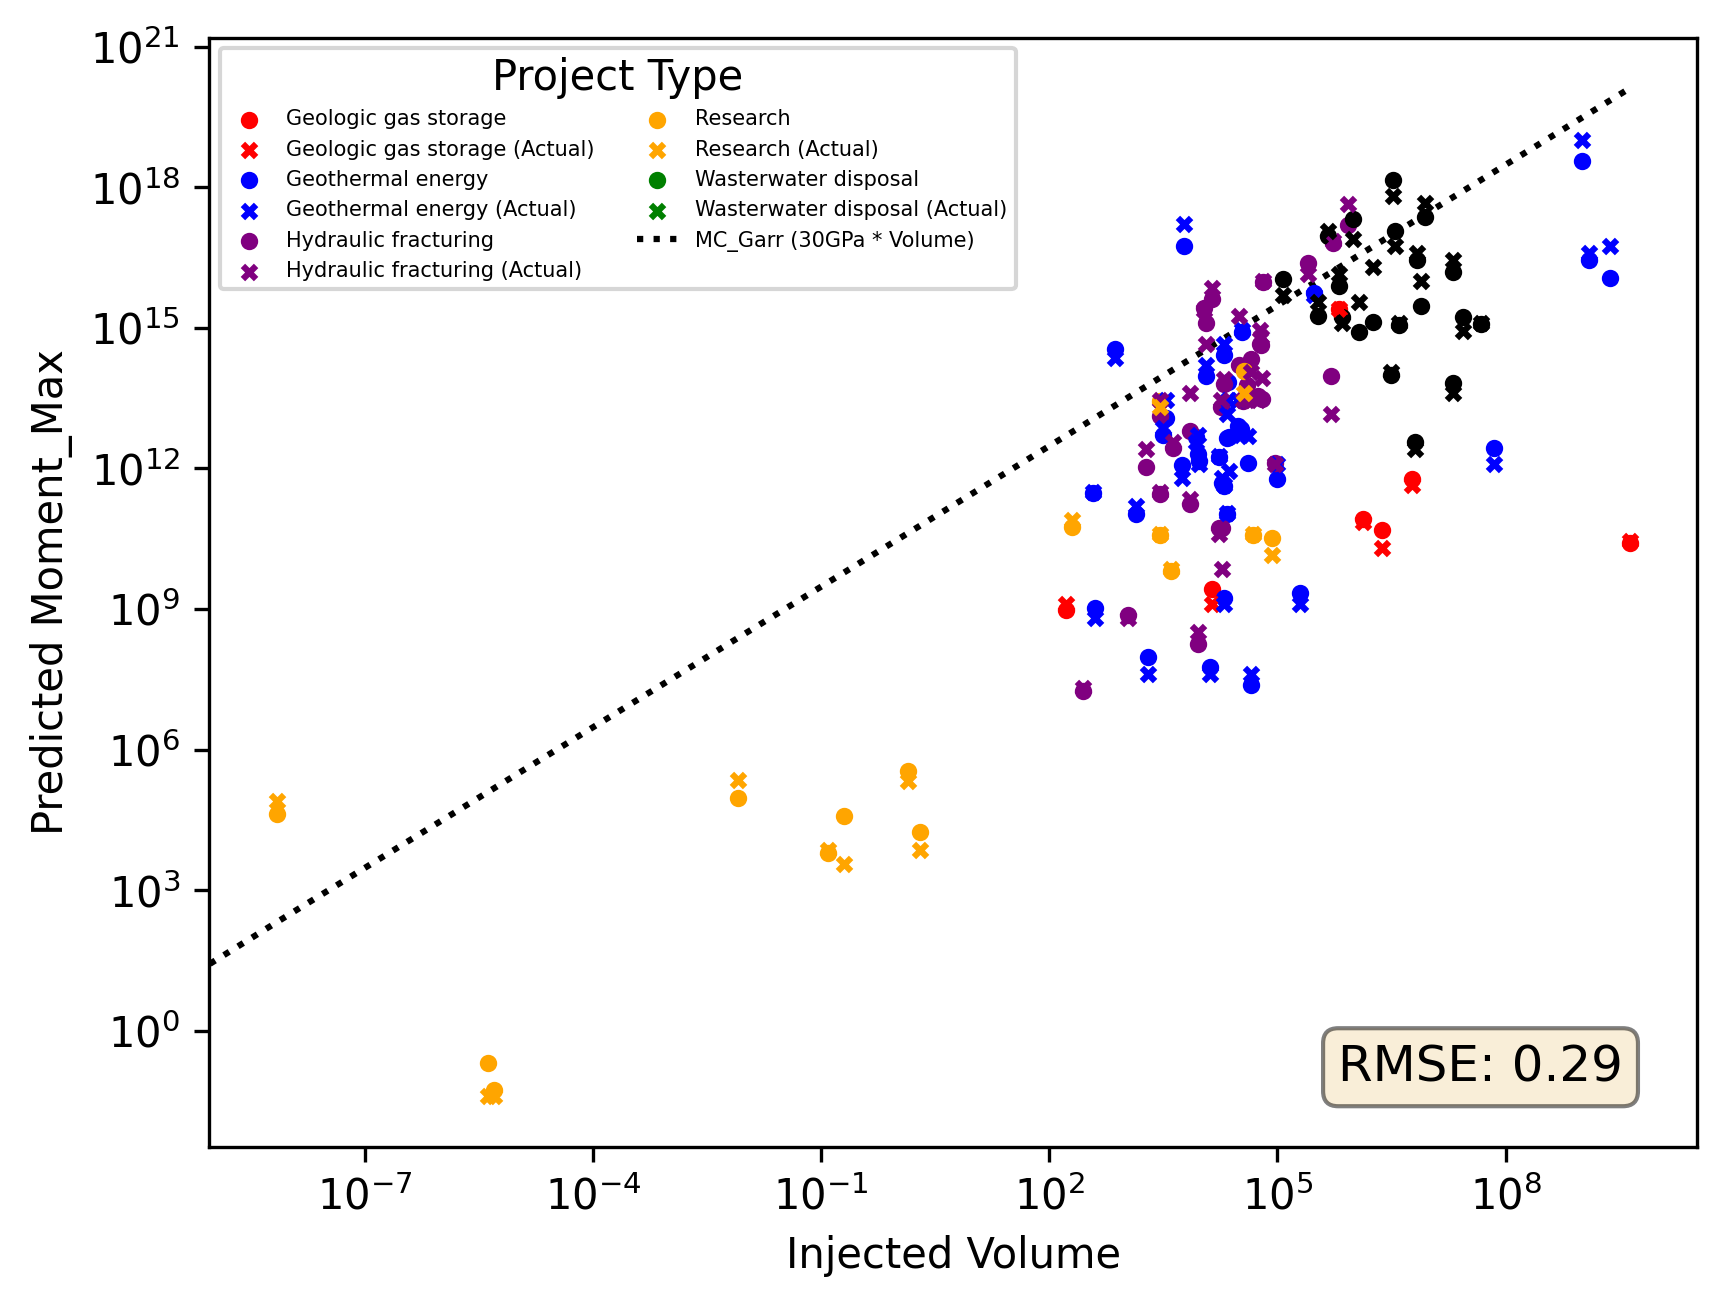

In [8]:
import numpy as np
import matplotlib.pyplot as plt
pred_data['Mo'] = 10 ** ((3/2) * (y_pred + 6.07))
pred_data['Mo_rec'] = 10 ** ((3/2) * (Y + 6.07))
X = pred_data['Injected Volume']
Y_MO_PRED = pred_data['Mo']
Y_MO_REC = pred_data['Mo_rec']
Y_SM = pred_data['Shear Modulus']

trend = X * 30e9 # Trend values

# Color mapping
to_color = {
    'Geologic gas storage': 'red',
    'Geothermal energy': 'blue',
    'Hydraulic fracturing': 'purple',
    'Research': 'orange',
    'Wasterwater disposal': 'green'
}

plt.figure(dpi=300)

# Plot predicted Mo values per project type (circle markers)
for i in range(len(pred_data)):
    x_val = X.iloc[i]
    y_val_pred = Y_MO_PRED.iloc[i]
    project_type = pred_data['Project_Type'].iloc[i]
    color = to_color.get(project_type, 'black')
    plt.scatter(x_val, y_val_pred, color=color, s=10, zorder=2)  # Predicted: circle

# Plot recovered Mo values per project type (X markers)
for i in range(len(pred_data)):
    x_val = X.iloc[i]
    y_val_rec = Y_MO_REC.iloc[i]
    project_type = pred_data['Project_Type'].iloc[i]
    color = to_color.get(project_type, 'black')
    plt.scatter(x_val, y_val_rec, color=color, s=10, marker='x', zorder=3)  # Actual: X

# Sort X and trend for proper line plotting
sorted_indices = np.argsort(X)
X_sorted = X.iloc[sorted_indices]
trend_sorted = trend.iloc[sorted_indices]

# Plot the trend as a dotted line
plt.plot(X_sorted, trend_sorted, color='black', linestyle=':', linewidth=1.5, zorder=1)

# RMSE annotation
textstr = f'RMSE: {rmse:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=props)

# Axis labels and log scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Injected Volume")
plt.ylabel("Predicted " + obj_param)

# Custom legend handles
for project, color in to_color.items():
    plt.scatter([], [], color=color, s=10, label=project)  # For circles
    plt.scatter([], [], color=color, s=10, marker='x', label=f"{project} (Actual)")  # For Xs

plt.plot([], [], color='black', linestyle=':', label='MC_Garr (30GPa * Volume)')
plt.legend(fontsize=5, title="Project Type", loc='best', ncol=2)

# Save & show
file_path = f"PNGs/06_04/{title_1}.jpg"
# plt.savefig(file_path, format='jpg')
print(title_1)
plt.show()


Validation Plot_All_0.85


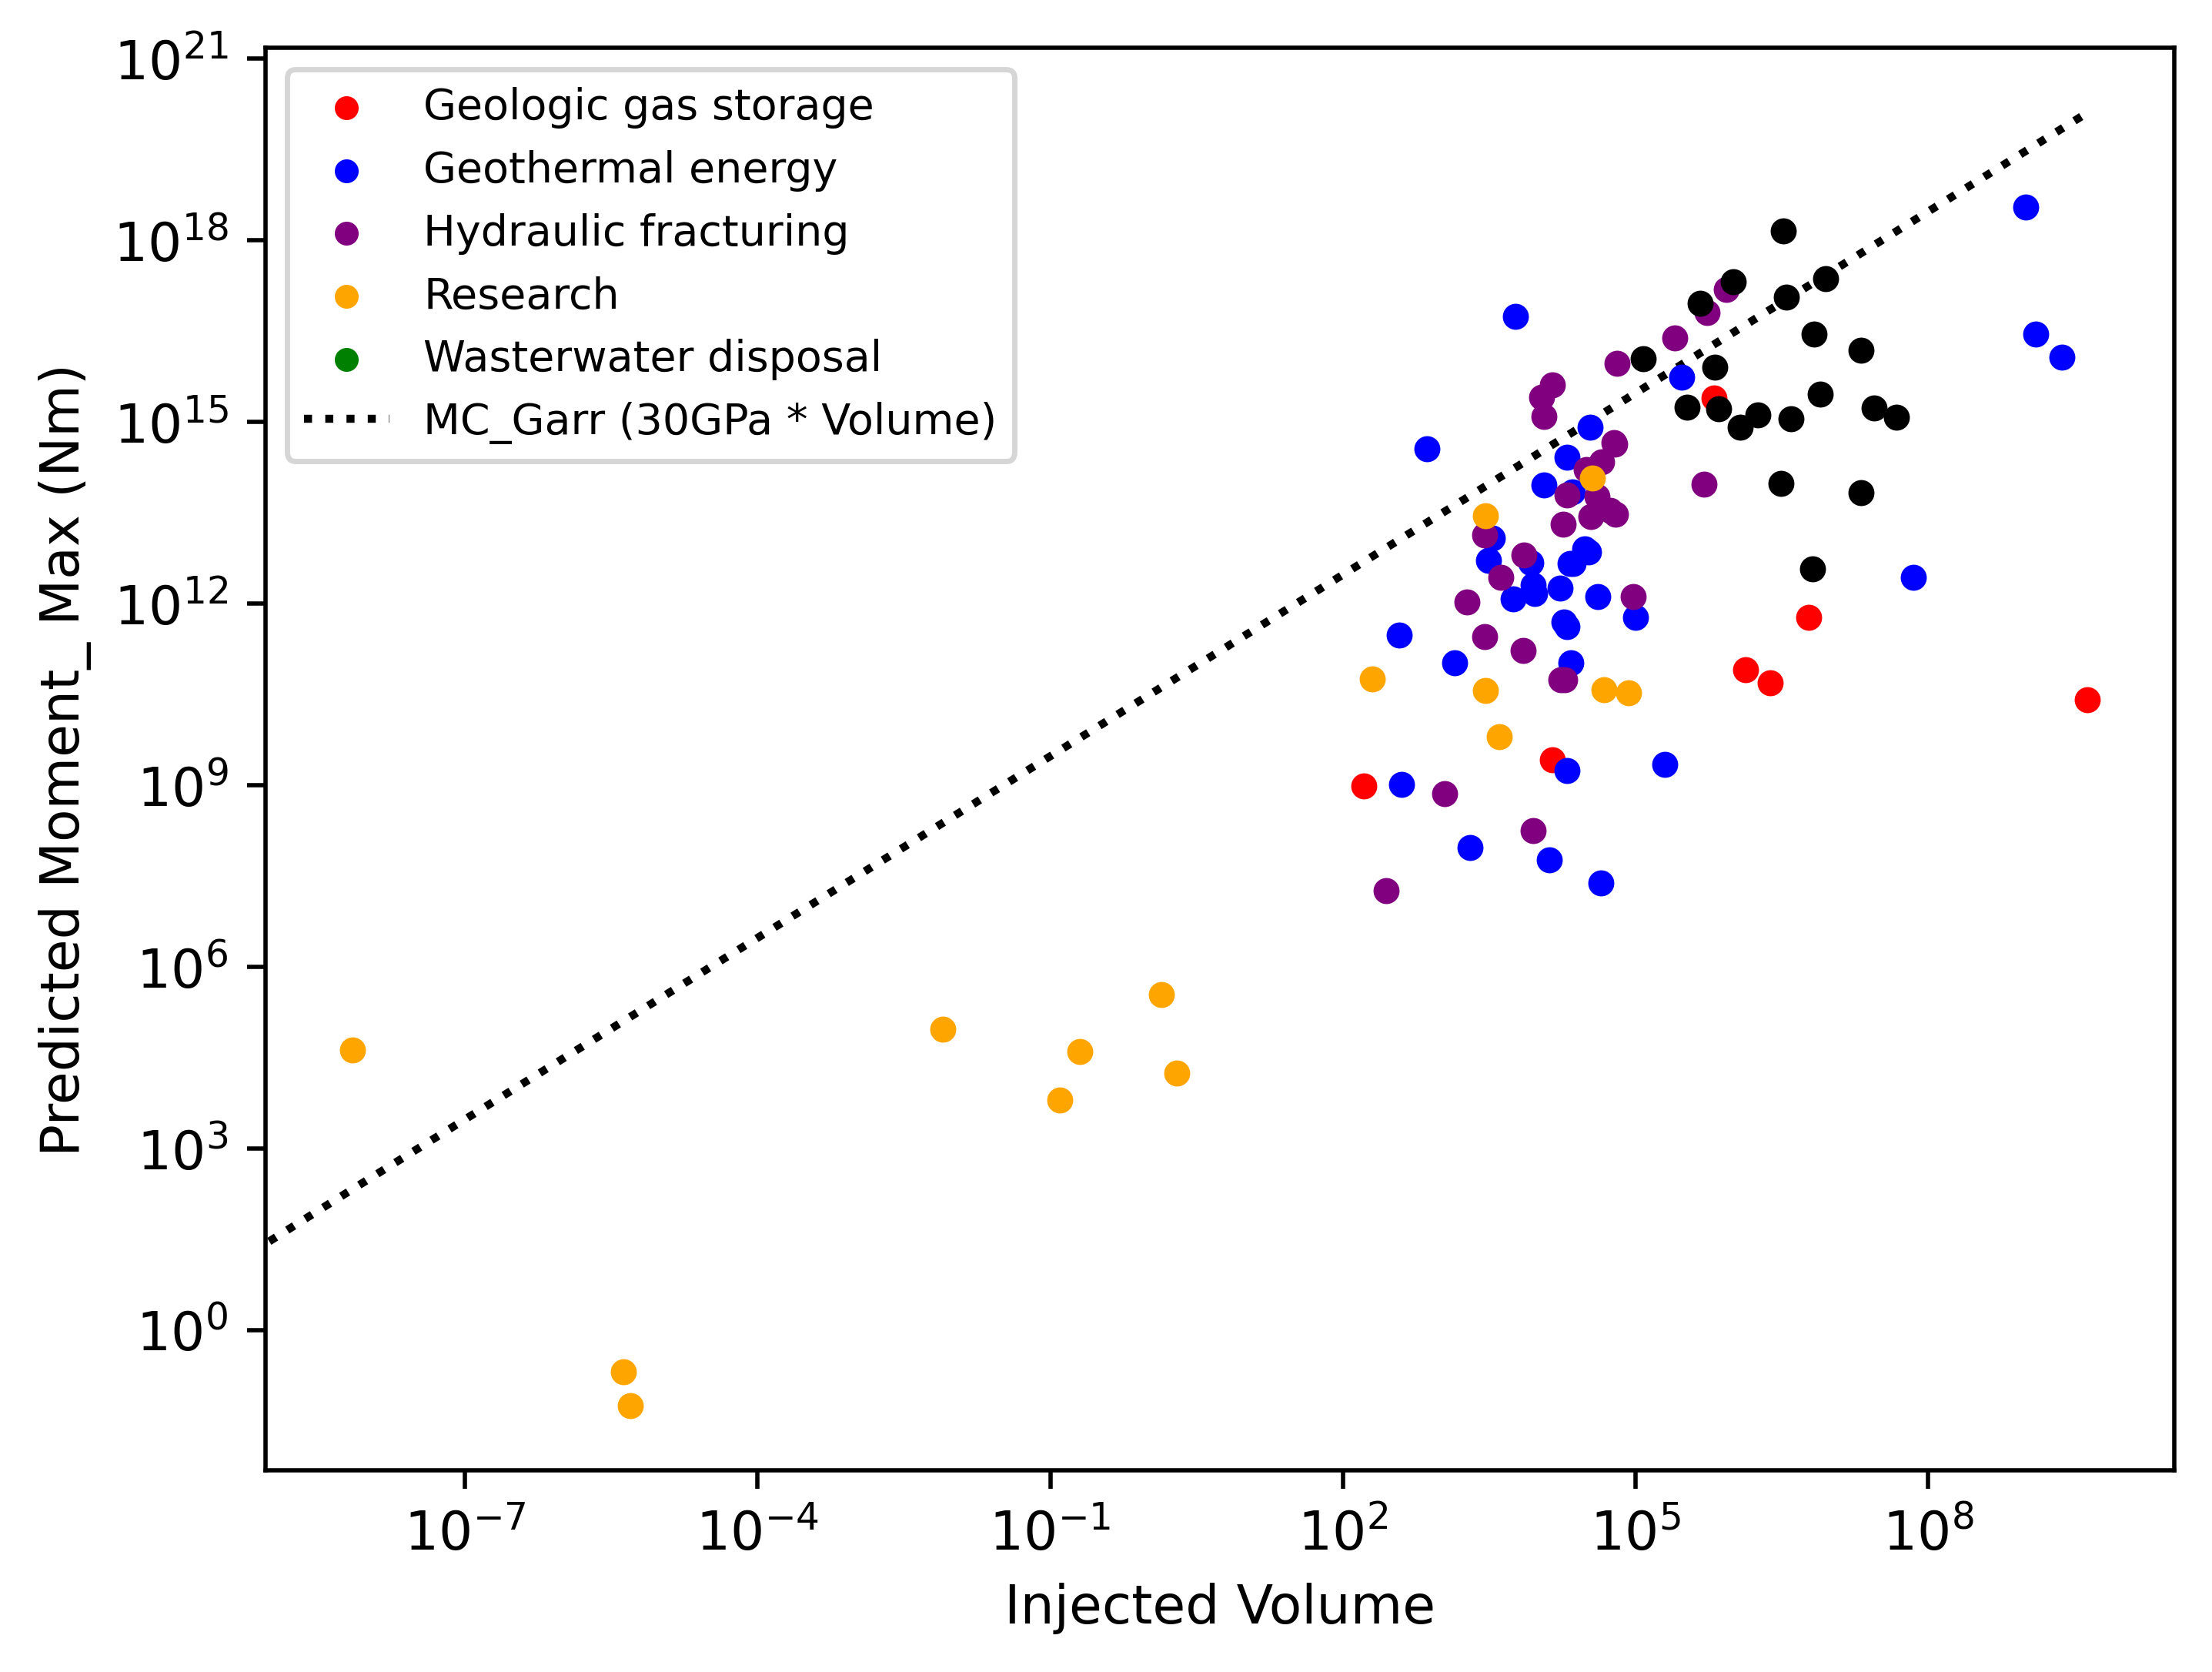

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate predicted moment
pred_data['Mo'] = 10 ** ((3/2) * (y_pred + 6.07))

X = pred_data['Injected Volume']
Y_MO_PRED = pred_data['Mo']
trend = X * 30e9  # MC_Garr trend

# Color mapping for project types
to_color = {
    'Geologic gas storage': 'red',
    'Geothermal energy': 'blue',
    'Hydraulic fracturing': 'purple',
    'Research': 'orange',
    'Wasterwater disposal': 'green'
}

plt.figure(dpi=500)

# Plot predicted Mo as colored circles
for i in range(len(pred_data)):
    x_val = X.iloc[i]
    y_val_pred = Y_MO_PRED.iloc[i]
    project_type = pred_data['Project_Type'].iloc[i]
    color = to_color.get(project_type, 'black')

    plt.scatter(x_val, y_val_pred, color=color, s=15, marker='o', zorder=2)

# Plot MC_Garr trend line
sorted_indices = np.argsort(X)
X_sorted = X.iloc[sorted_indices]
trend_sorted = trend.iloc[sorted_indices]
plt.plot(X_sorted, trend_sorted, color='black', linestyle=':', linewidth=1.5, zorder=1)


# Axes and scales
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Injected Volume", fontsize=10)
plt.ylabel("Predicted Moment_ Max (Nm)", fontsize=10)

# Legend setup for predicted Mo
for project, color in to_color.items():
    plt.scatter([], [], color=color, marker='o', s=12, label=project)

plt.plot([], [], color='black', linestyle=':', label='MC_Garr (30GPa * Volume)')
plt.legend(fontsize=8, title_fontsize=8, loc='best', ncol=1)

# Save & show
file_path = f"PNGs/06_04/{title_1}.jpg"
# plt.savefig(file_path, format='jpg')
print(title_1)
plt.show()


In [10]:
# Get feature importances from the model
importances = model.feature_importance()
feature_names = model.feature_name()

# Step 1: Create a mapping from underscore names → original names (with spaces)
col_mapping = {col.replace(" ", "_"): col for col in pred_data.columns}

# Step 2: Map feature names back to their original names using the mapping
original_feature_names = [col_mapping.get(f, f) for f in feature_names]

# Step 3: Create DataFrame using the original feature names
feature_importance_df = pd.DataFrame({
    'Feature': original_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Create a list of features sorted by importance
feature_order_col = feature_importance_df['Feature'].tolist()

# Optional: Check mapping output
print(Pred_m1_data.columns.tolist())


['Bulk Density', 'Effective Porosity', 'Intrinsic Permeability', "Poisson's Ratio", 'Shear Modulus', 'Biot Coefficinet', 'Injected Volume', 'Injected Depth', 'Injected Rate']


In [11]:
import shap
shap_data = Pred_m1_data

# SHAP explainer
explainer = shap.TreeExplainer(model, feature_perturbation="auto")
shap_values = explainer.shap_values(shap_data)
shap_df = pd.DataFrame(shap_values, columns=shap_data.columns)


feature_order_col = [col for col in feature_order_col if col in shap_data.columns]

Reorder_SHAP = shap_df[feature_order_col]
Reorder_Pred = shap_data[feature_order_col]

Reorder_SHAP.to_excel(f"CSVs/ML_Inputs/{sheet_name}_SHAP.xlsx", index=False)
Reorder_Pred.to_excel(f"CSVs/ML_Inputs/{sheet_name}_Pred.xlsx", index=False)
reoder_shap_values = Reorder_SHAP.values

print(Reorder_SHAP.columns,Reorder_Pred.columns)

# Plot SHAP summary


Index(['Injected Rate', 'Injected Volume', 'Injected Depth',
       'Effective Porosity', 'Biot Coefficinet', 'Bulk Density',
       'Intrinsic Permeability', 'Shear Modulus', 'Poisson's Ratio'],
      dtype='object') Index(['Injected Rate', 'Injected Volume', 'Injected Depth',
       'Effective Porosity', 'Biot Coefficinet', 'Bulk Density',
       'Intrinsic Permeability', 'Shear Modulus', 'Poisson's Ratio'],
      dtype='object')


In [12]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Load data
Shape = pd.read_excel(f"CSVs/ML_Inputs/{sheet_name}_SHAP.xlsx")
pred = pd.read_excel(f"CSVs/ML_Inputs/{sheet_name}_Pred.xlsx")

# Assuming `reoder_shap_values` and `Reorder_Pred` are defined from Shape and pred
# Create plot
plt.figure(dpi=300)
plt.xlim(-3, 3)
plt.ylabel('Features')
plt.xlabel('SHAP Value')

# Create the SHAP summary plot
shap.summary_plot(
    reoder_shap_values[:1000, :],
    Reorder_Pred.iloc[:1000, :],
    plot_type="layered_violin",
    color="coolwarm",
    show=False  # Prevent automatic display
)
plt.figtext(0.01, 0.95, '(b)', fontsize=12, ha='left', va='top')
plt.savefig("PNGs/shap_summary_plot.jpg", dpi=500)
plt.close()



<Axes: >

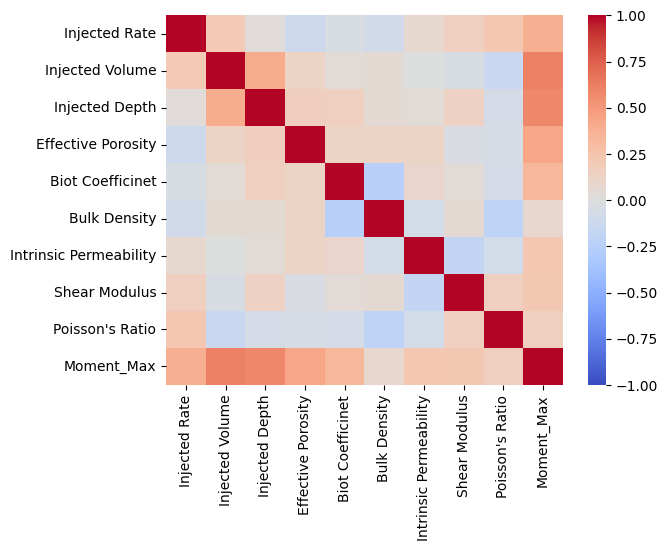

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create SHAP value DataFrame with proper feature names
shap_df = pd.DataFrame(reoder_shap_values, columns=Reorder_Pred.columns)
shap_df[obj_param] = y_pred
shap_df.to_excel("CSVs/ML_Outputs/shap_values.xlsx", index=False)

shap_df = shap_df
shap_df_corr = shap_df.corr(method='spearman')
plt.figure(dpi=100)
sns.heatmap(shap_df_corr, cmap='coolwarm', cbar=True,vmin=-1, vmax=1)



C:\Users\Ssach\AppData\Local\Temp\ipykernel_27396\2540531882.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


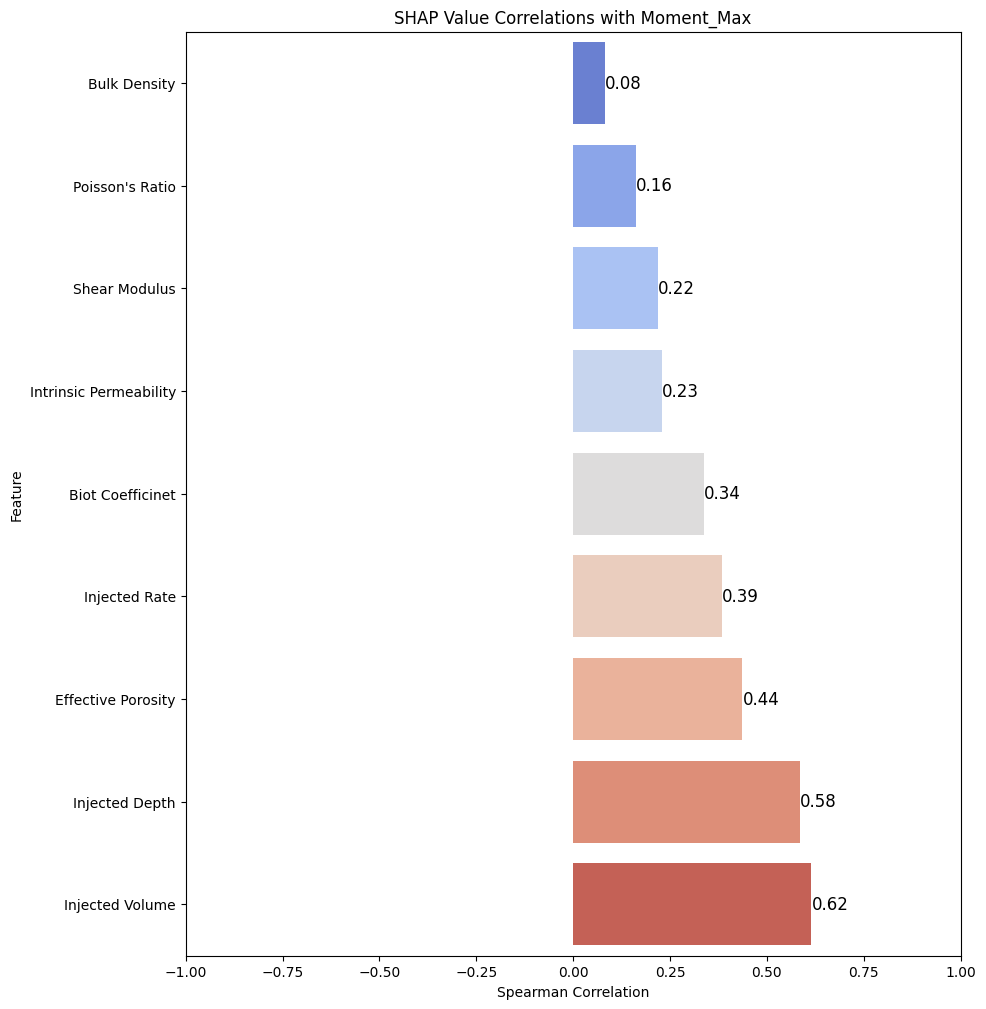

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop categorical column if it exists
shap_df_filtered = shap_df.drop(columns=['project_type'], errors='ignore')

# Compute Spearman correlation matrix
corel_shap = shap_df_filtered.corr(method='spearman')

# Extract correlation with Moment_Max
target_var = 'Moment_Max'
correlations = corel_shap[target_var].drop(target_var, errors='ignore')

# Create DataFrame for plotting
correlations_df = correlations.reset_index()
correlations_df.columns = ['feature', 'correlation']
correlations_df = correlations_df.sort_values(by='correlation', ascending=True).reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 12))
bar_plot = sns.barplot(
    x='correlation', 
    y='feature', 
    data=correlations_df, 
    palette='coolwarm',
)

# Annotate each bar
for index, row in correlations_df.iterrows():
    bar_plot.text(row['correlation'], 
                  index, 
                  f"{row['correlation']:.2f}", 
                  color='black', 
                  ha="left" if row['correlation'] > 0 else "right", 
                  va="center", 
                  fontsize=12)

plt.xlim(-1, 1)
plt.title(f'SHAP Value Correlations with {target_var}')
plt.xlabel('Spearman Correlation')
plt.ylabel('Feature')

# Save
file_path = f"PNGs/SHAP_Correlations_with_{target_var}.jpg"
plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=300)

# Show
plt.show()


                  feature  correlation
0            Bulk Density    -0.166623
1  Intrinsic Permeability    -0.108707
2        Biot Coefficinet     0.003768
3         Poisson's Ratio     0.051303
4          Injected Depth     0.062908
5           Shear Modulus     0.089636
6      Effective Porosity     0.150453
7           Injected Rate     0.220025
8         Injected Volume     0.239168


C:\Users\Ssach\AppData\Local\Temp\ipykernel_27396\3032199044.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


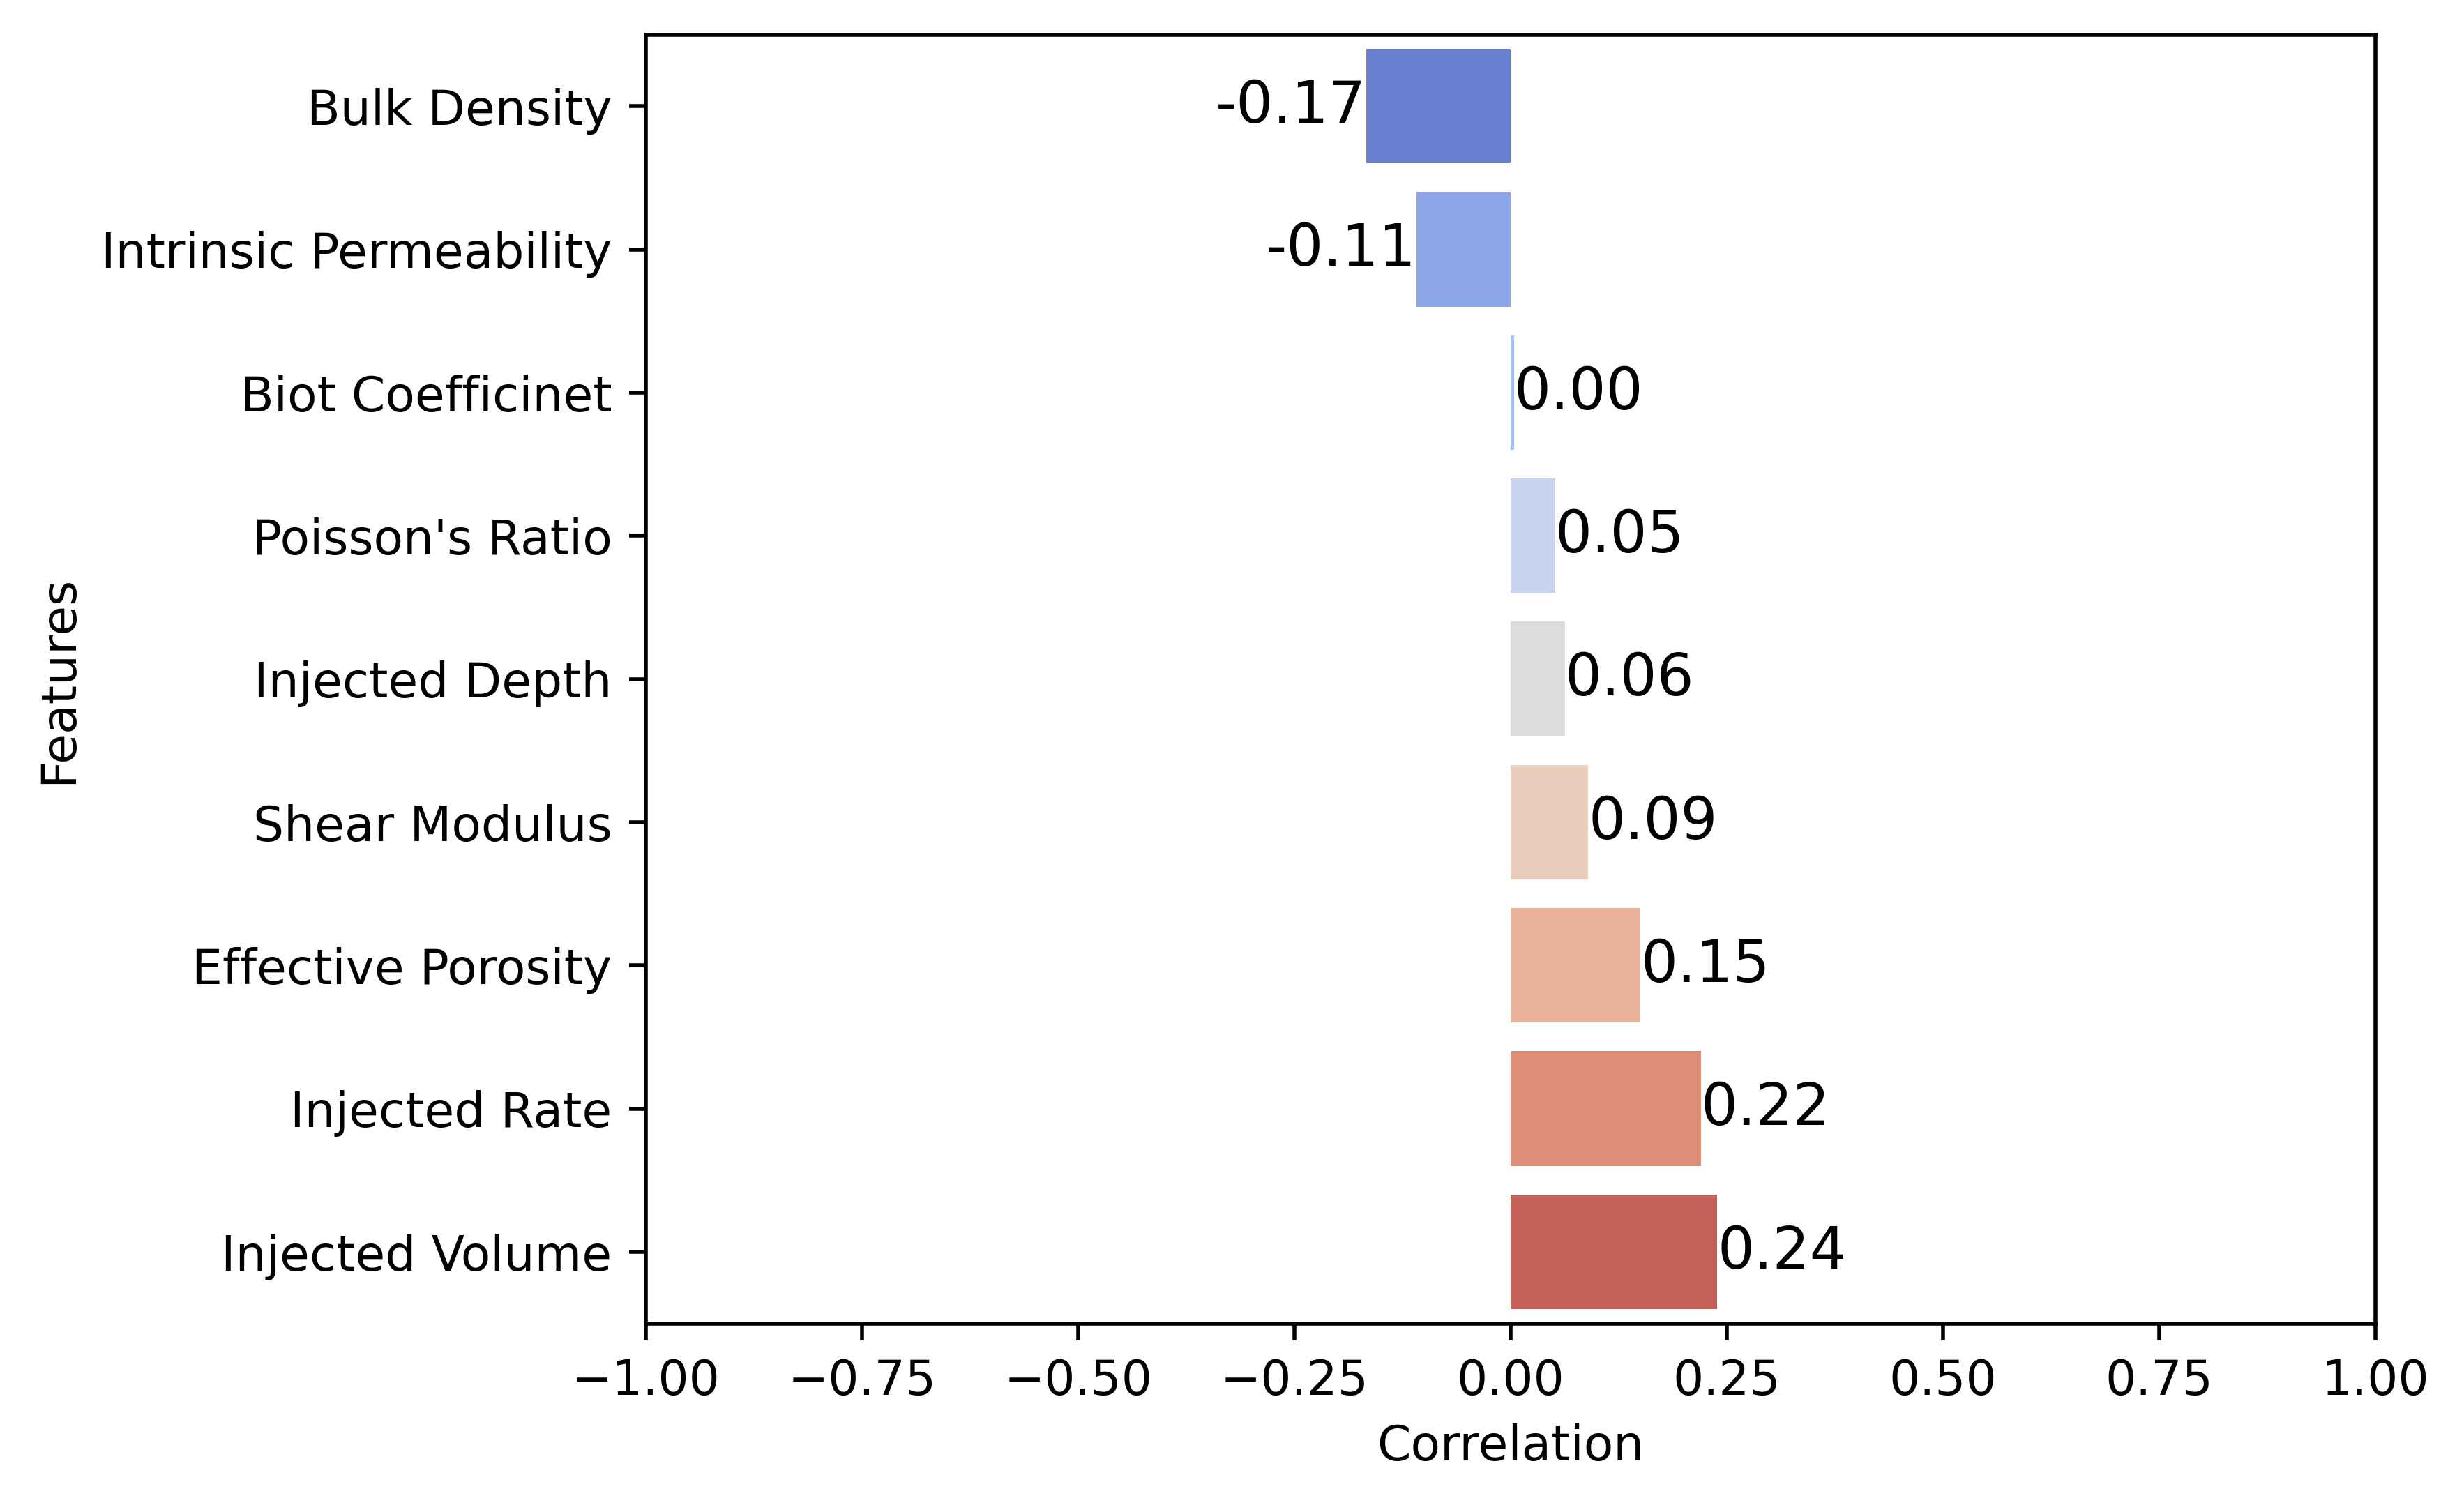

In [15]:

data_corr= predicted_df.select_dtypes(include=['number'])
# Corelation matrix 
corel = data_corr.corr(method='spearman')

target_var = 'Moment_Max'
correlations = corel[target_var].drop(target_var, errors='ignore')  # Drop self-correlation if it exists

# Convert to a DataFrame for easier plotting
correlations_df = correlations.reset_index()
correlations_df.columns = ['feature', 'correlation']
correlations_df = correlations_df.sort_values(by='correlation', ascending=True).reset_index(drop=True)
print(correlations_df)

# Sort by absolute correlation values
#correlations_df = correlations_df.reindex(correlations_df['correlation'].abs().sort_values(ascending=False).index)

# Plot the bar plot

plt.figure(dpi=500)
bar_plot = sns.barplot(
    x='correlation', 
    y='feature', 
    data=correlations_df, 
    palette='coolwarm',
)

# Add annotations for correlation values
for index, row in correlations_df.iterrows():
    bar_plot.text(row['correlation'], 
                  index, 
                  f"{row['correlation']:.2f}", 
                  color='black', 
                  ha="left" if row['correlation'] > 0 else "right", 
                  va="center", 
                  fontsize=12)

# Set x-axis limits to -1 and 1
plt.xlim(-1, 1)

# Add title and labels
#plt.title(f'Spearman Correlations with {target_var}')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.grid(False)
# Save the plot
file_path = f"PNGs/06_04/Spearman_Correlations_with_Predicted_{target_var}.jpg"
plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=500)

# Show the plot
plt.show()

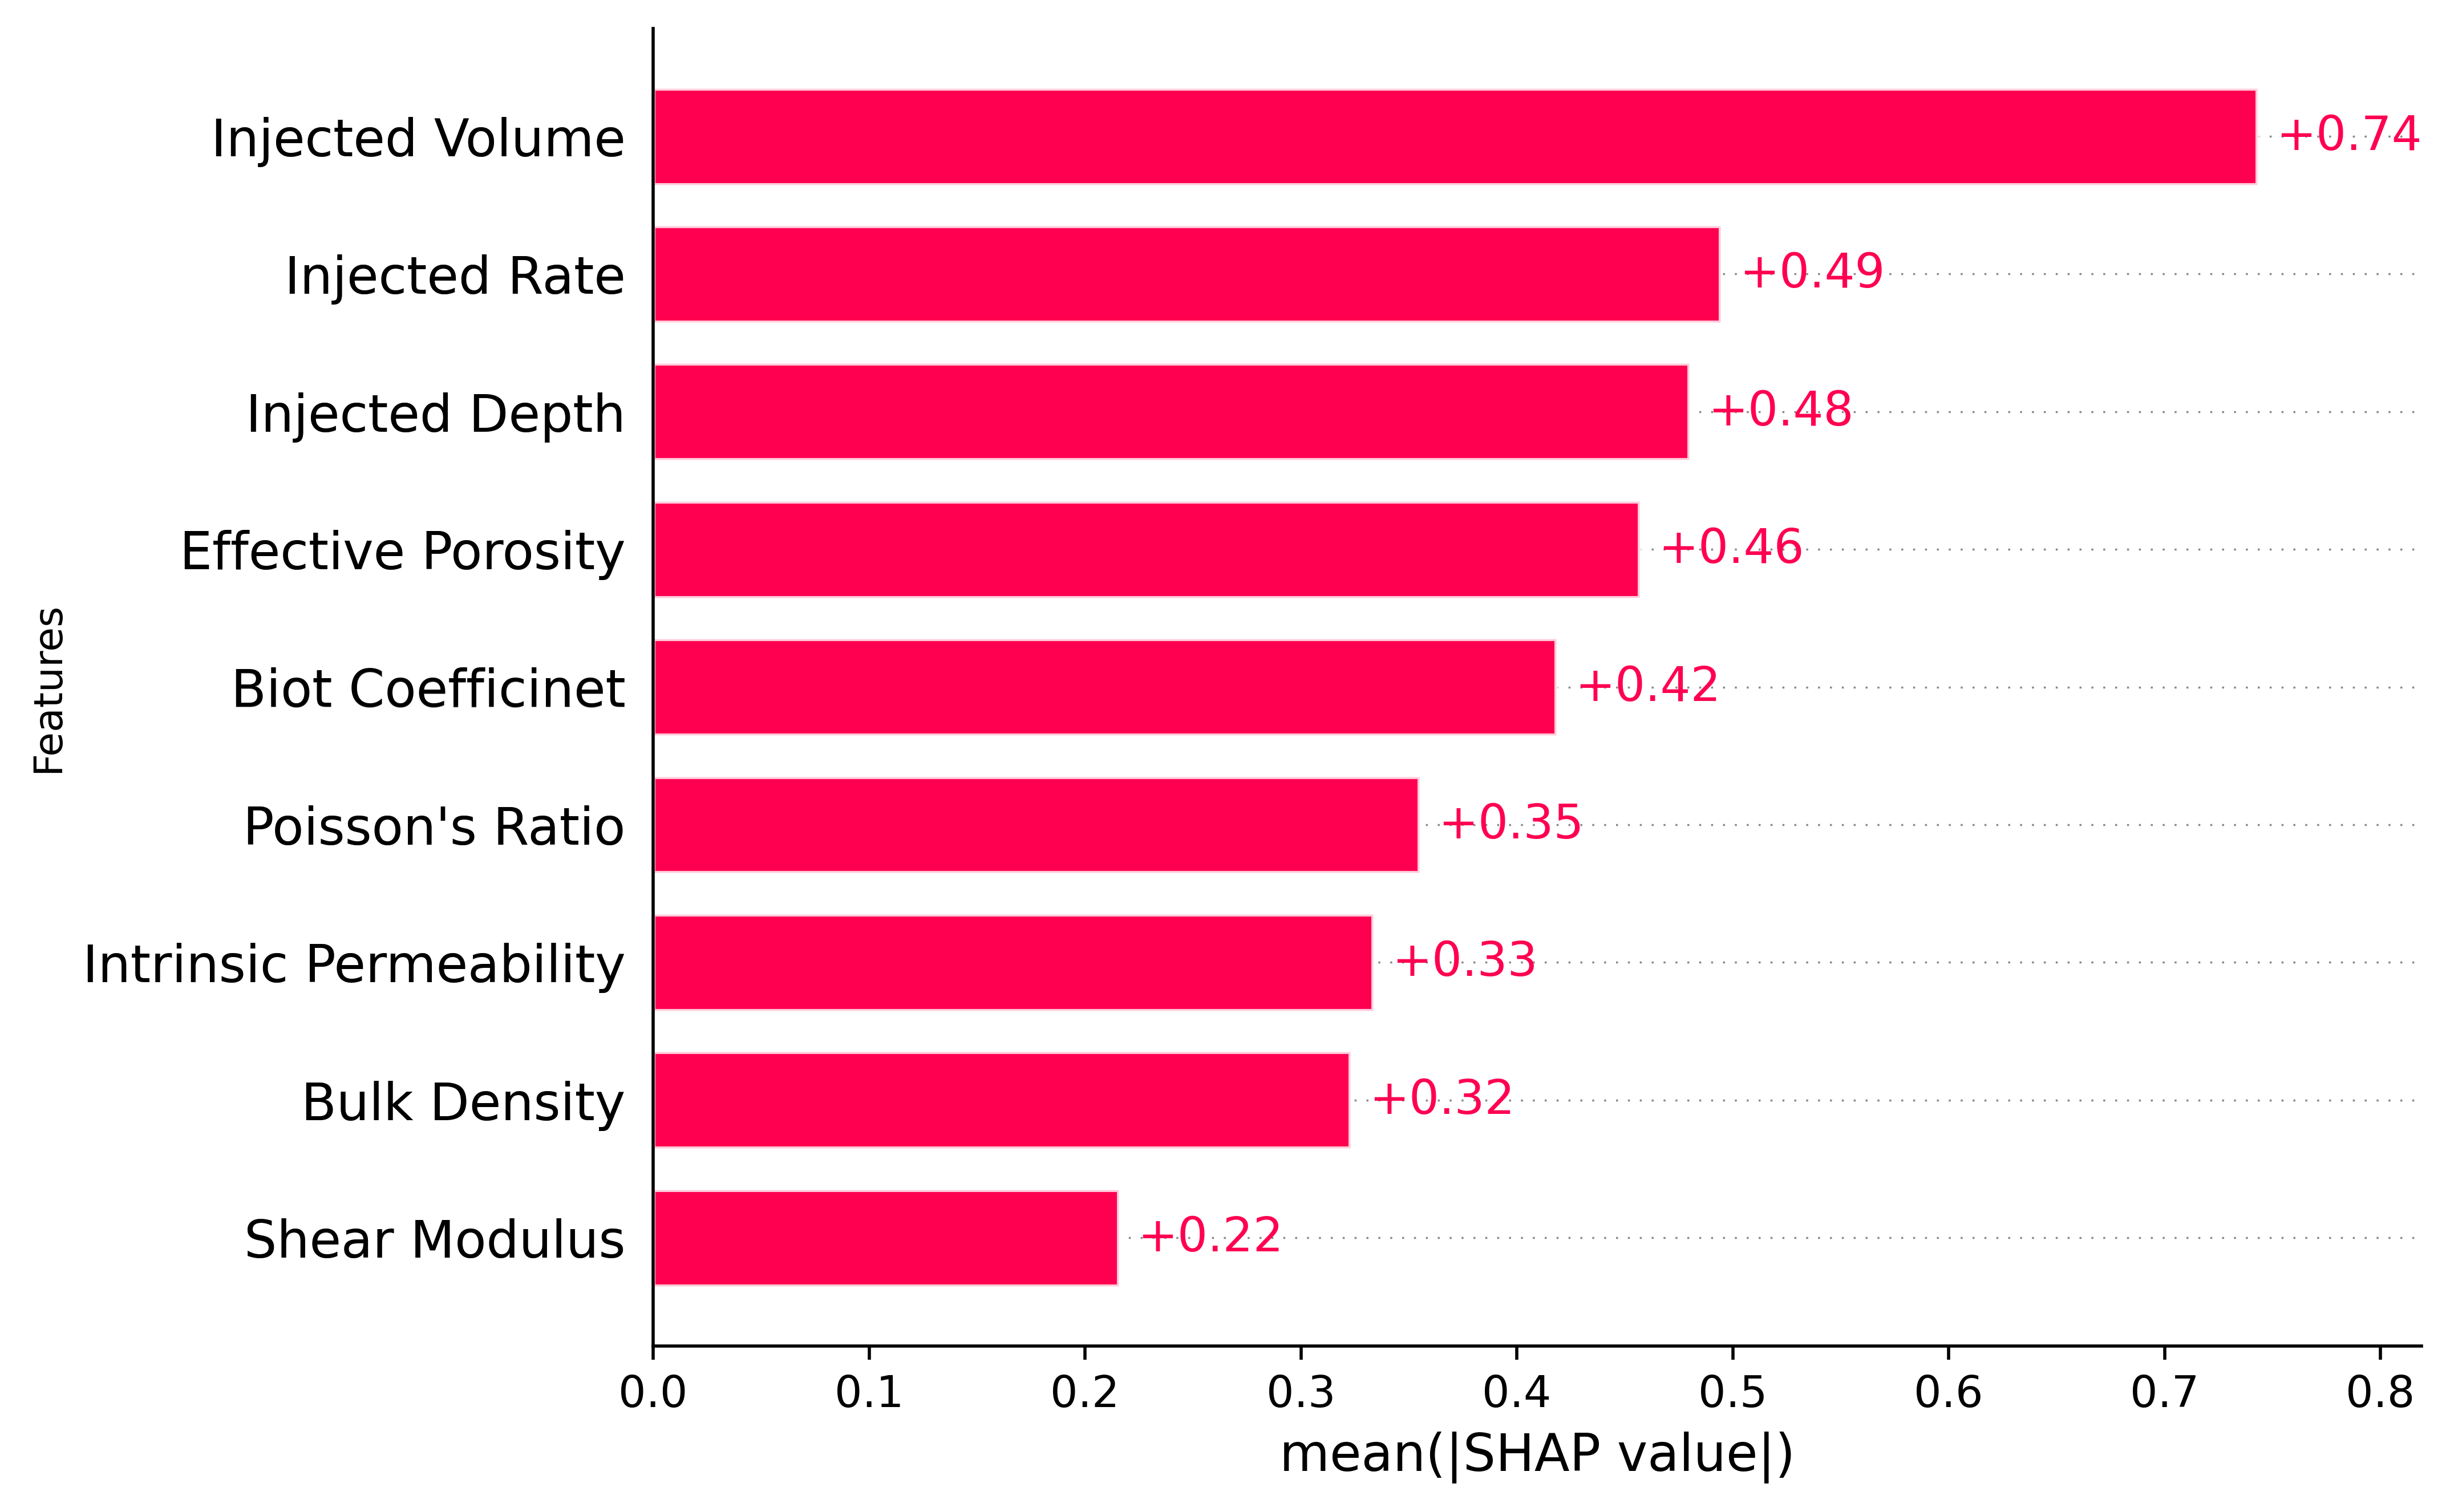

In [16]:
# Create a SHAP Explanation object
shap_explanation = shap.Explanation(
    values=shap_values,  # SHAP values
    base_values=(shap_values),  # Base value (mean of SHAP values)
    data=Pred_m1_data,  # Feature data
    feature_names=Pred_m1_data.columns.tolist()  # Feature names
)
import matplotlib.cm as cm
# Plot the SHAP bar plot
color ='red'

# Plot with higher resolution and updated palette
plt.figure(dpi=500)
plt.ylabel('Features')
shap.plots.bar(shap_explanation, max_display=17) # Show top 10 features

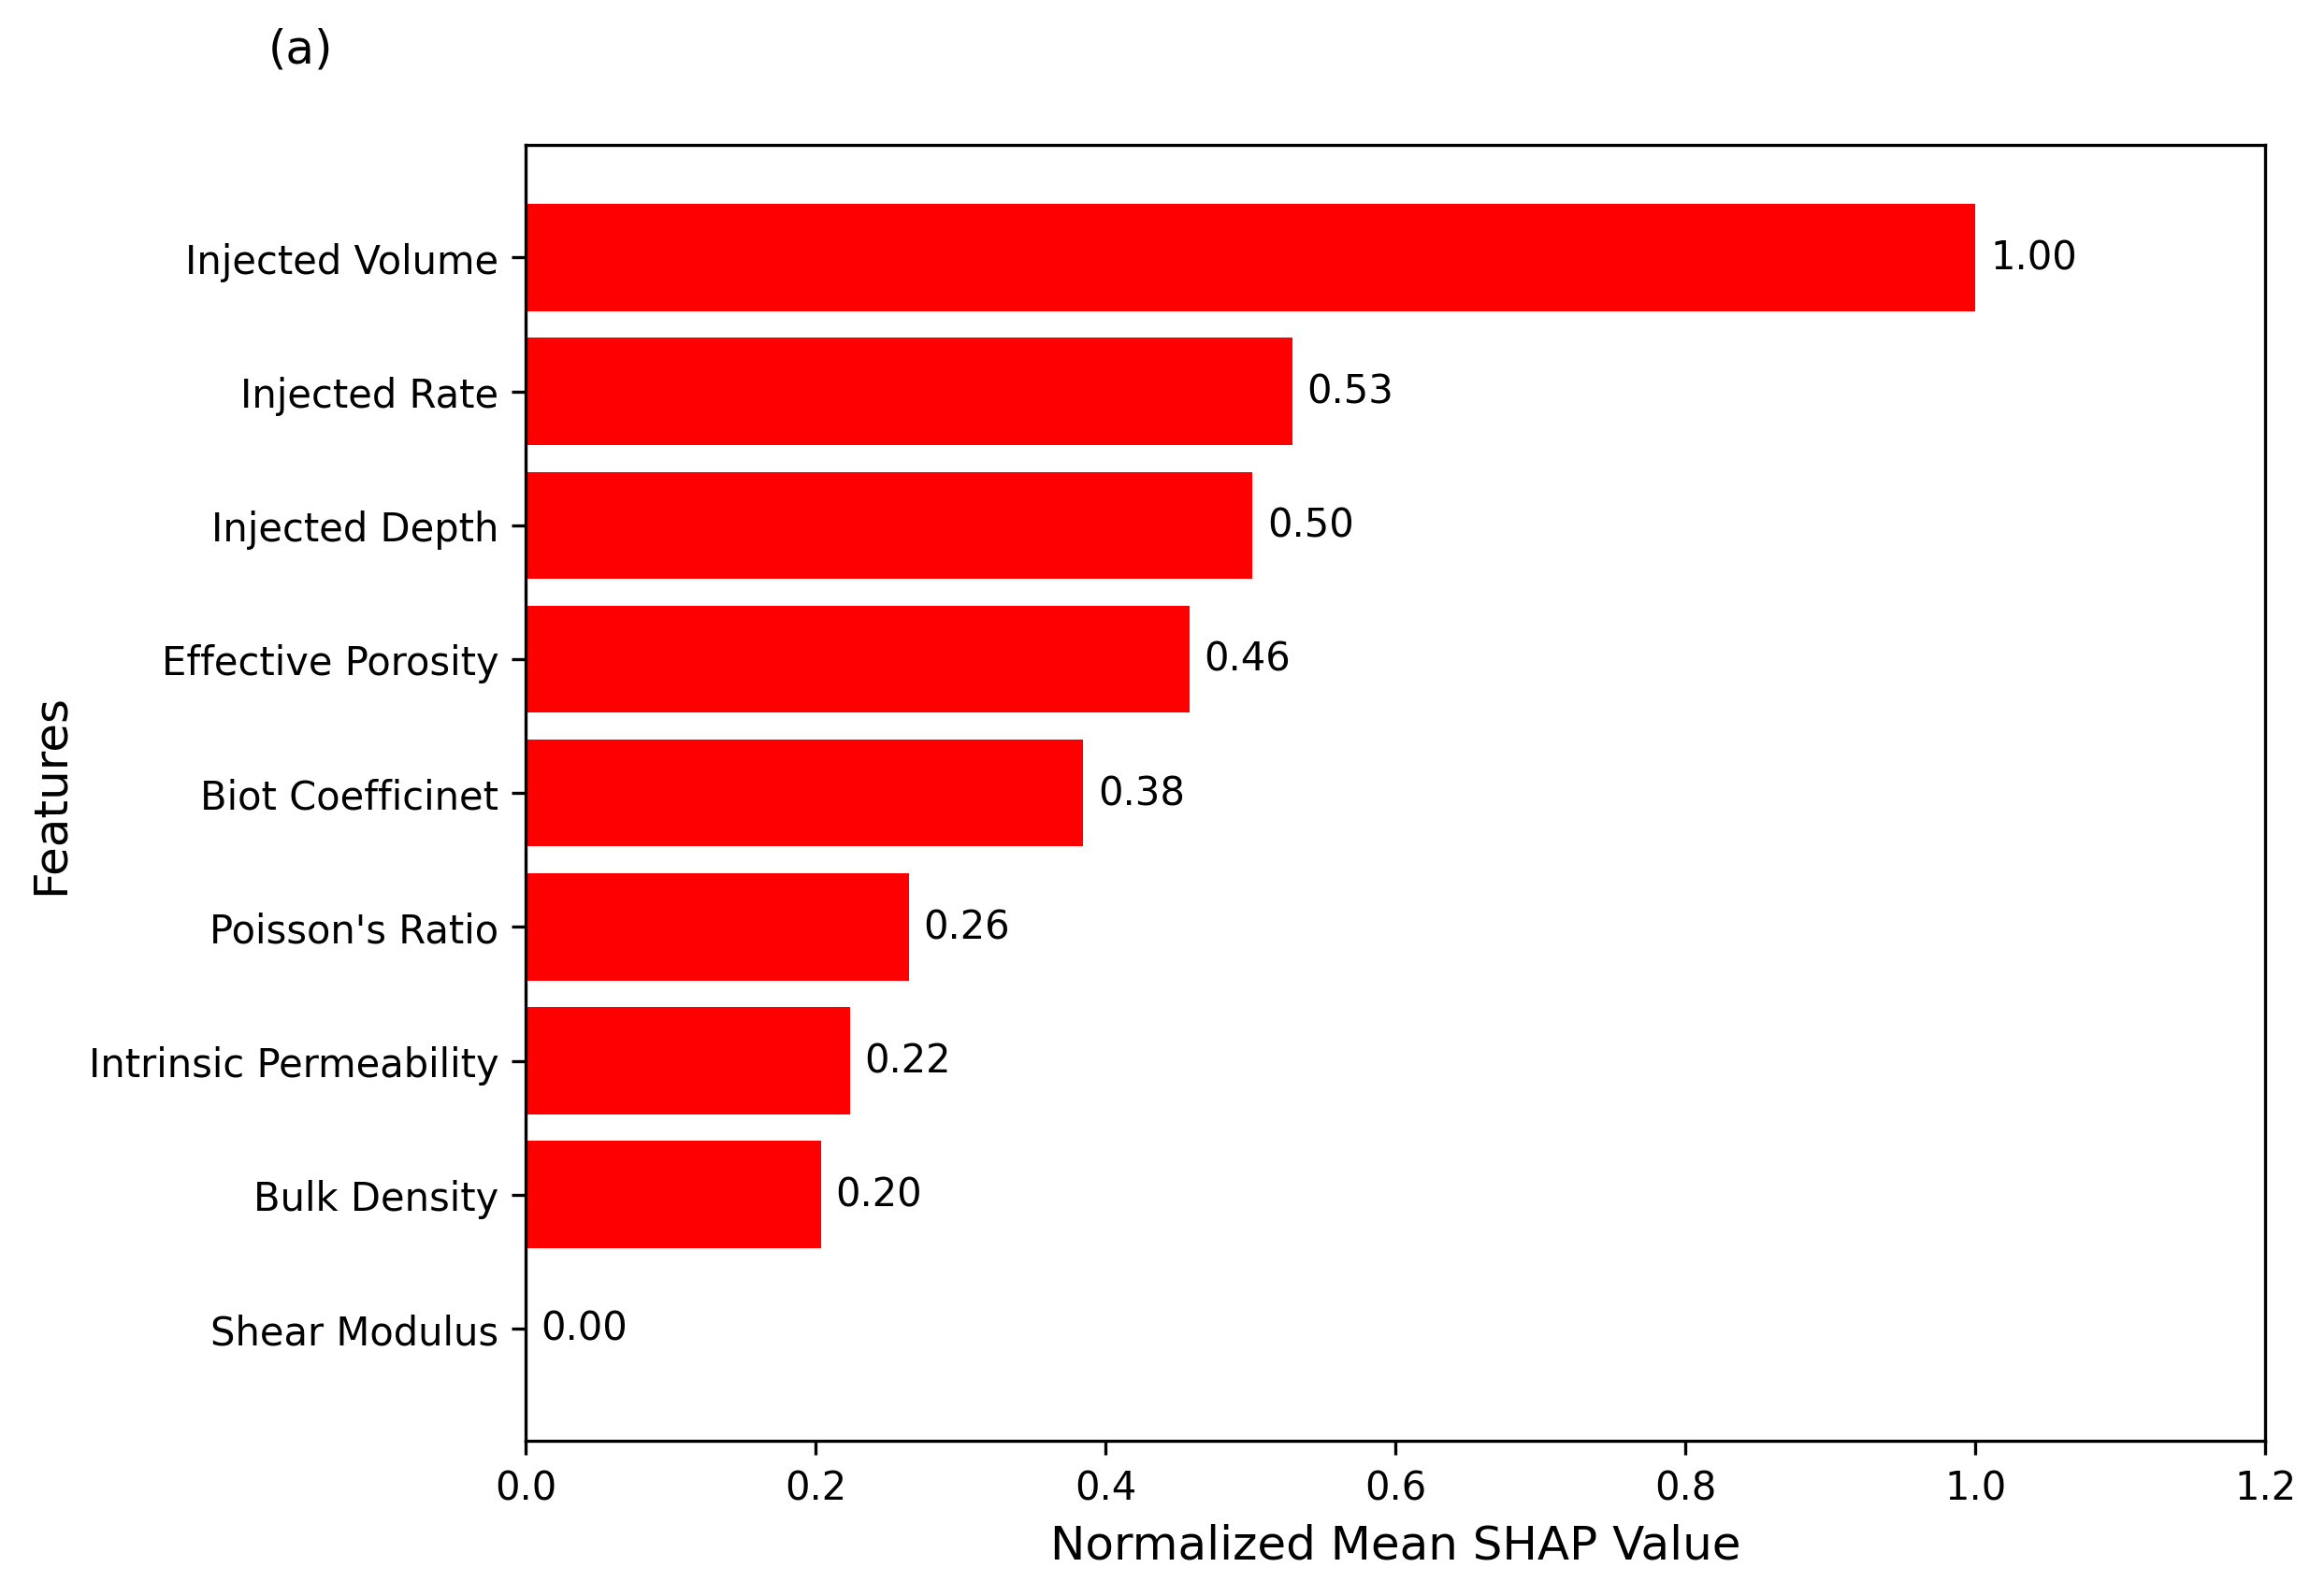

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate mean absolute SHAP values for each feature
shap_mean = pd.DataFrame({
    'feature': Reorder_Pred.columns,
    'mean_shap_value': np.abs(reoder_shap_values).mean(axis=0)
})

# Normalize the mean SHAP values
shap_mean['normalized_mean_shap_value'] = (
    (shap_mean['mean_shap_value'] - shap_mean['mean_shap_value'].min()) /
    (shap_mean['mean_shap_value'].max() - shap_mean['mean_shap_value'].min())
)

# Sort by normalized mean SHAP values in descending order
shap_mean = shap_mean.sort_values(by='normalized_mean_shap_value', ascending=False).reset_index(drop=True)

# Plot the normalized mean SHAP values as a bar plot
plt.figure(figsize=(8, 6), dpi=300)
bar_plot = plt.barh(
    shap_mean['feature'], 
    shap_mean['normalized_mean_shap_value'], 
    color='red'
)

# Add annotations for normalized values
for index, value in enumerate(shap_mean['normalized_mean_shap_value']):
    plt.text(
        value + 0.01,  # Position slightly to the right of the bar
        index, 
        f"{value:.2f}",  # Format to 2 decimal places
        va='center', 
        fontsize=10
    )

# Add labels and title
plt.xlabel('Normalized Mean SHAP Value', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.xlim(0, 1.2)  # Set x-axis limits
# Reverse the y-axis to show the highest values at the top
plt.gca().invert_yaxis()
plt.figtext(0.01, 0.95, '(a)', fontsize=12, ha='left', va='top')
# Save and show the plot
file_path = f"PNGs/Normalized_Mean_SHAP_Values.jpg"
plt.savefig(file_path, format='jpg', bbox_inches='tight',dpi=300)
plt.show()

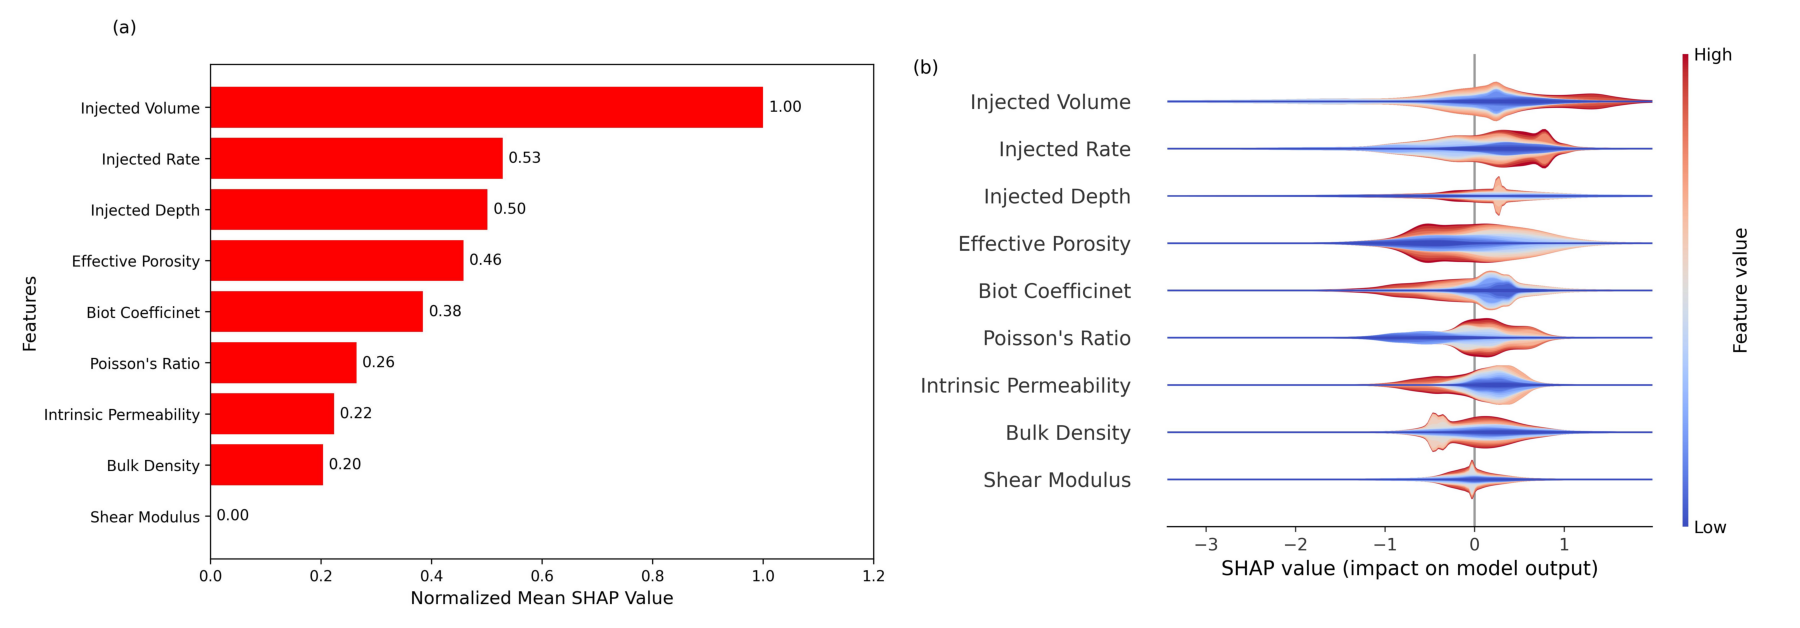

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

# File paths for the images
file_path_a = "PNGs/Normalized_Mean_SHAP_Values.jpg"
file_path_b = "PNGs/shap_summary_plot.jpg"

try:
    # Load the images
    img_a = Image.open(file_path_a)
    img_b = Image.open(file_path_b)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2,figsize=(20,10))

    # Plot the first image
    axes[0].imshow(img_a)
    axes[0].axis('off')  # Turn off axes
    
    # Plot the second image
    axes[1].imshow(img_b)
    axes[1].axis('off')  # Turn off axes
    
    plt.subplots_adjust(left=0.1, right=0.99,wspace=0.01)
    plt.savefig(file_path, dpi=300)
    plt.show()

    # Save and show the plot
    file_path = "PNGs/Final.jpg"
    

except FileNotFoundError as e:
    print(f"Error: {e}. Please check if the file paths are correct and the images exist.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")